Cyna Shirazinejad, 7/7/21

# Notebook 16: analyze N-WASP dynamics

outline:
* find N-WASP CCPs
* measure the effect of N-WASP recruitment to CME dynamics

##### user parameters to toggle plot-generation and/or dataframe construction and corresponding calculations

##### import all necessary Python modules

In [11]:
%load_ext autoreload
%autoreload 2
# %autosave 60
import sys, os, pandas as pd, numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import imageio
from skimage import exposure
import seaborn as sns
import warnings
from scipy import signal
import scipy.interpolate as interpolate
import pickle
from IPython.display import Image, display
import warnings
%matplotlib inline

unique_user_path_notebook = str(np.load('unique_user_path_notebook.npy'))
unique_user_saved_outputs = str(np.load('unique_user_saved_outputs.npy'))
unique_user_path_tracks = str(np.load('unique_user_path_tracks.npy'))

sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts')
import display_tracks
import separate_tracking_merge_tools
import merge_tools
import generate_index_dictionary
import return_track_attributes
import alignment
import feature_extraction_with_buffer

index_dictionary = generate_index_dictionary.return_index_dictionary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataframe from notebook 3 containing normal-pdf scaled features: PC's and GMM predicted clusters, and dataframe with cmeAnalysis labels

In [12]:
'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/arpc3_notebook_outputs_2colormodelalldata/dataframes/df_nwasp_data_pcs_gmm_clusters.zip'

'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/arpc3_notebook_outputs_2colormodelalldata/dataframes/df_nwasp_data_pcs_gmm_clusters.zip'

In [13]:
unique_user_saved_outputs+'/dataframes/df_nwasp_data_pcs_gmm_clusters.zip'

'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs/dataframes/df_nwasp_data_pcs_gmm_clusters.zip'

In [14]:
unique_user_saved_outputs

'/Volumes/GoogleDrive/My Drive/Drubin Lab/ap2dynm2arcp3_project/stable_outputs'

In [15]:
df_pcs_normal_scaled_with_gmm_cluster = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_nwasp_data_pcs_gmm_clusters.zip')
df_merged_features = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_nwasp_data_merged_features.zip')
index_dnm2positive = np.load(unique_user_saved_outputs+'/dataframes/cluster_dnm2_positive.npy', allow_pickle=True)
number_of_track_splits = np.load(unique_user_saved_outputs+'/dataframes/number_of_track_splits.npy', allow_pickle=True)
number_of_clusters = np.load(unique_user_saved_outputs+"/dataframes/number_of_clusters.npy", allow_pickle=True)
ccp_predictions = np.load(unique_user_saved_outputs+'/dataframes/nwasp_ccp_predictions.npy',allow_pickle=True)

In [16]:
best_fit_peak_params = np.load(unique_user_saved_outputs+'/dataframes/parameters_best_fit_peak_finding.npy')
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')

In [17]:
df_merged_features

lifetime  max_int_ap2  max_int_dnm2  dist_traveled_ap2  \
0         181.0   838.846885    289.035166           7.221133   
1         173.0   648.969353    447.208676           3.812234   
2         172.0   456.305535    375.334291          19.447658   
3         166.0   426.657333    257.105949          14.902804   
4         161.0   125.206766    194.809135           8.032639   
...         ...          ...           ...                ...   
54653       2.0    13.878499     36.276701           5.615461   
54654       2.0    45.284413     17.115350           0.818345   
54655       2.0    15.530743      3.396067           2.704094   
54656       2.0    10.886942     13.268407           2.353457   
54657       2.0    25.708122     25.970929           0.930578   

       dist_traveled_dnm2  max_dist_between_ap2_dnm2    md_ap2   md_dnm2  \
0               11.919019                   4.888317  0.378804  0.700272   
1                5.007210                   4.533374  0.197433  0.550535   
2               16.506035                   4.124215  0.281681  0.709564   
3               11.834867                   3.237402  0.346493  0.676118   
4                9.648622                   3.170784  0.489029  1.004908   
...                   ...                        ...       ...       ...   
54653            7.292761                   6.053937  3.072350  2.191784   
54654            1.593482                   5.020380  1.580574  1.588437   
54655            0.895306                   3.936657  2.038662  2.712819   
54656            5.631699                   3.838392  1.837788  2.514516   
54657            1.461967                   3.443789  1.650813  1.350484   

       time_to_peak_ap2  time_to_peak_dnm2  ...  kurtosis_dnm2  \
0                 134.0              103.0  ...      -0.911852   
1                 126.0              170.0  ...       4.862636   
2                 134.0              156.0  ...       3.046904   
3                 113.0              164.0  ...      -0.793608   
4                 127.0               52.0  ...       4.516333   
...                 ...                ...  ...            ...   
54653              11.0                8.0  ...      -0.058747   
54654               6.0               10.0  ...      -1.245731   
54655               5.0               11.0  ...      -1.134241   
54656               6.0                7.0  ...      -1.199704   
54657               6.0                9.0  ...       0.216961   

       number_significant_dnm2  max_consecutive_significant_dnm2  \
0                        167.0                             118.0   
1                        151.0                              44.0   
2                        146.0                              79.0   
3                        129.0                             116.0   
4                         78.0                              24.0   
...                        ...                               ...   
54653                      1.0                               1.0   
54654                      0.0                               0.0   
54655                      0.0                               0.0   
54656                      0.0                               0.0   
54657                      1.0                               1.0   

       fraction_significant_dnm2  fraction_peak_ap2  fraction_peak_dnm2  \
0                       0.874346           0.701571            0.539267   
1                       0.825137           0.688525            0.928962   
2                       0.802198           0.736264            0.857143   
3                       0.732955           0.642045            0.931818   
4                       0.456140           0.742690            0.304094   
...                          ...                ...                 ...   
54653                   0.083333           0.916667            0.666667   
54654                   0.000000           0.500000            0.833333   
54655                   0.00

# loading all N-WASP4 tracks originating from two experiments

In [18]:
nwasp_tracks = []

tracks_180803ADWCell001_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_001/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell001nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180803ADWCell002_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_002/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell002nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180803ADWCell003_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_003/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell003nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180803ADWCell004_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_004/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell004nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180803ADWCell005_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_005/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell005nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180803ADWCell006_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_006/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell006nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')

# 7/18/18

tracks_180718ADWCell001_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_001/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell001nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180718ADWCell002_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_002/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell002nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')
tracks_180718ADWCell003_1s=display_tracks.load_tracks(unique_user_path_tracks + '/ap2dynm2arcp3_project/TIRF movies revised/tracking_data_test_cyna/180803_ADW/split_channel_data/180803_ADW_003/tracking_settings_gaussian_psf_model_trackinggaplength_2_trackingradius_3_6/180803ADWCell003nwasp_1s/Ch1/Tracking/ProcessedTracks.mat')

nwasp_tracks.append(tracks_180803ADWCell001_1s)
nwasp_tracks.append(tracks_180803ADWCell002_1s)
nwasp_tracks.append(tracks_180803ADWCell003_1s)
nwasp_tracks.append(tracks_180803ADWCell004_1s)
nwasp_tracks.append(tracks_180803ADWCell005_1s)
nwasp_tracks.append(tracks_180803ADWCell006_1s)

nwasp_tracks.append(tracks_180718ADWCell001_1s)
nwasp_tracks.append(tracks_180718ADWCell002_1s)
nwasp_tracks.append(tracks_180718ADWCell003_1s)

In [19]:
print('total number of nwasp tracking experiments: ' + str(len(nwasp_tracks)))

total number of nwasp tracking experiments: 9


In [20]:
valid_tracks_nwasp = [display_tracks.remove_tracks_by_criteria(track_set, track_category=[1, 2]) for track_set in nwasp_tracks]

The number of tracks returned: 15439

The number of tracks returned: 15105

The number of tracks returned: 17045

The number of tracks returned: 20243

The number of tracks returned: 16113

The number of tracks returned: 21321

The number of tracks returned: 15439

The number of tracks returned: 15105

The number of tracks returned: 17045



# save all valid N-WASP tracks

In [21]:
for i in range(len(valid_tracks_nwasp)):
    
    np.save(unique_user_saved_outputs+"/dataframes/valid_nwasp_tracks_"+str(i), np.array(list(valid_tracks_nwasp[i])), allow_pickle=True)

# load all valid N-WASP tracks

In [22]:
valid_tracks_nwasp = [np.load(unique_user_saved_outputs+'/dataframes/valid_nwasp_tracks_0.npy',allow_pickle=True)]

for i in range(1,9):
    
    valid_tracks_nwasp += [np.load(unique_user_saved_outputs+'/dataframes/valid_nwasp_tracks_'+str(i)+'.npy',allow_pickle=True)]

In [23]:
merged_valid_tracks_nwasp = merge_tools.merge_experiments(valid_tracks_nwasp,[list(range(len(track_set))) for track_set in valid_tracks_nwasp])

# load all valid tracks

In [24]:
merged_all_valid_tracks = np.load(unique_user_saved_outputs+'/dataframes/merged_all_valid_nwasp_tracks_0.npy', allow_pickle=True)

for i in range(1, number_of_track_splits):

    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                              np.load(unique_user_saved_outputs+'/dataframes/merged_all_valid_nwasp_tracks_'+str(i)+'.npy', allow_pickle=True)))

In [25]:
merged_all_valid_tracks.shape

(54658,)

In [26]:
num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

for i in range(num_gmm_clusters):

    gmm_classes.append(df_pcs_normal_scaled_with_gmm_cluster[df_pcs_normal_scaled_with_gmm_cluster['gmm_predictions']==i].index.values)    

In [27]:
len(gmm_classes[index_dnm2positive])

5337

In [28]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [29]:
len(tracks_authentic_ccps_gmm)

5337

# isolate hot-spot and individual CCP mixed authentic CCP class from gmm

In [30]:
experiment_number_track_candidates = df_merged_features['experiment_number'][gmm_classes[index_dnm2positive]] # experiment numbers (1-16)

In [31]:
len(experiment_number_track_candidates)

5337

# separate single-CCP events by experiment

In [32]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 
hotspot_events_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted hot-spots 
ccp_events_per_experiment = []

for experiment_number in range(9): # only look at 3-color movies
    
    current_exp_ind = np.where(experiment_number_track_candidates==experiment_number)[0] # all events in current experiment
    hotspot_pred_exp = ccp_predictions[current_exp_ind] # hot-spot predictions for current experiment
    tracks_exp = tracks_authentic_ccps_gmm[current_exp_ind] # all tracks in current experiment
    
    non_hotspot_ind = np.where(hotspot_pred_exp==1)[0] # single ccp event indices
    tracks_single_ccp_exp = tracks_exp[non_hotspot_ind] # single ccp tracks
    ccp_events_per_experiment.append(tracks_single_ccp_exp)

<!-- # measure ap2 initiation to dnm2 peak lifetime, comparing 2 cell lines -->

# merge all CCPs

In [33]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

# create trees of N-WASP locations per frame

In [34]:
nwasp_trees = []

for experiment_number in range(9):  
    
    print(experiment_number)
    nwasp_experiment=valid_tracks_nwasp[experiment_number-9] # nwasp tracks in experiment
    
    # build a tree for each movie frame for all tracks included in the frame
    kd_tree_nwasp_experiment, vals_tree = separate_tracking_merge_tools.build_kd_tree_channel(nwasp_experiment,
                                                                                              0,
                                                                                              241)
    nwasp_trees.append([kd_tree_nwasp_experiment, vals_tree])

0
1
2
3
4
5
6
7
8


# save KDTrees and corresponding value matrices for index matching

In [35]:
for i in range(9):
    
    tree = nwasp_trees[i-9][0]
    values = nwasp_trees[i-9][1]
    
    with open(unique_user_saved_outputs+'/dataframes/nwasp_kdtree_'+str(i), 'wb') as f:
        pickle.dump(tree, f)                

    np.save(unique_user_saved_outputs+"/dataframes/nwasp_tree_index_matrix_"+str(i), values, allow_pickle=True)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# reload (or load) trees 

In [36]:
nwasp_trees = []

for i in range(9):
    
    with open(unique_user_saved_outputs+'/dataframes/nwasp_kdtree_'+str(i), 'rb') as f:
        tree = pickle.load(f)
        
    index_matrix = np.load(unique_user_saved_outputs+"/dataframes/nwasp_tree_index_matrix_"+str(i)+'.npy', allow_pickle=True)

    nwasp_trees.append([tree, index_matrix])

In [37]:
def angle_between(p1, p2): # from stackoverflow
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

In [38]:
warnings.filterwarnings("ignore")
distance_query = 2 # pixel search radius for associating ap2 and nwasp from separate tracking

# nwasp positive events, padded in non-overlapping frames
ch0_vectors_nwasp_positive = [] # amplitudes #
ch1_vectors_nwasp_positive = [] #
ch2_vectors_nwasp_positive = [] #
channel_0_1_separations_nwasp_positive = [] # distance in microns between ap2 and dnm2
channel_0_2_separations_nwasp_positive = [] # distance in microns between ap2 and nwasp
channel_1_2_separations_nwasp_positive = []
final_separations_ap2nwasp_nwasp_positive = [] # ap2 and nwasp final separation in last overlapping frame of ap2 and nwasp
initial_separations_ap2nwasp_nwasp_positive = [] # ap2 and nwasp initial separation in first overlapping frame of ap2 and nwasp
ap2_nwasp_separation_at_dnm2_peak_nwasp_positive = [] # ap2 and nwasp separation at peak of dnm2 signal
ap2_nwasp_separation_at_nwasp_peak_nwasp_positive = []
ap2_nwasp_separation_at_ap2_peak_nwasp_positive = []
ap2_lifetime_nwasp_positive = [] # ap2 lifetime
nwasp_lifetime_nwasp_positive = []
max_separation_ap2_nwasp_nwasp_positive = [] # maximum separation between ap2 and nwasp
max_separation_ap2_dnm2_nwasp_positive = []
max_separation_dnm2_nwasp_nwasp_positive = []
num_frames_associated_nwasp_positive = [] # number of frames shared between ap2 and nwasp in movie that are below the query radius in KDTree search
time_ap2_appearance_to_dnm2_peak_nwasp_positive = []
maximum_ap2_intensity_nwasp_positive = []
maximum_dnm2_intensity_nwasp_positive = []
maximum_nwasp_intensity_nwasp_positive = []
pval_nwasp_ccps_nwasp_positive = []
time_nwasp_appearance_to_dnm2_peak_nwasp_positive = []
fraction_nwasp_positive = []
ccps_nwasp_positive = []
average_ap2_movement_before_dnm2_peak_nwasp_positive = []
ap2_nwasp_separation_average_nwasp_positive = []
experiment_number_nwasp_positive = []

# nwasp negative events
ch0_vectors_nwasp_negative = []
ch1_vectors_nwasp_negative = []
channel_0_1_separations_nwasp_negative = []
ccps_nwasp_negative = []
time_ap2_appearance_to_dnm2_peak_nwasp_negative = []
ap2_lifetime_nwasp_negative = []
experiment_number_nwasp_negative = []


num_no_neighbors = 0

for experiment_number in range(9):  # iterate over all experiments

    
    num_with_mode = 0 # count number of events with and without nwasp
    num_without_mode = 0    

    print('current experiment number: ' + str(experiment_number))
    ap2dmn2_tracks_in_experiment = ccp_events_per_experiment[experiment_number-9] # filtered tracks
    print('number of ap2 tracks: ' + str(len(ap2dmn2_tracks_in_experiment)))
    nwasp_experiment=valid_tracks_nwasp[experiment_number-9] # cat 1 and 2 nwasp events in experiment
    print('number of nwasp tracks: ' + str(len(nwasp_experiment)))

    
    # select a tree for each frame containing all events in each frame
    kd_tree_nwasp_experiment, vals_tree = nwasp_trees[experiment_number-9]
    
    print('iterating through tracks in experiment')
    
    for track_num in range(len(ap2dmn2_tracks_in_experiment)): # iterate through all ap2 tracks in experiment

        
        frames_in_track_first_channel = list(return_track_attributes.return_frames_in_track_no_buffer(ap2dmn2_tracks_in_experiment, track_num)-1) # frames of ap2 and dnm2
        ch0_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # positions of ap2 and dnm2
        ch0_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0)
        ch1_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ch1_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ap2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # ap2 and dnm2 intensities
        dnm2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        
        filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])
    
        dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                      distance=best_fit_peak_params[0], 
                                      height=best_fit_peak_params[1],
                                      width=best_fit_peak_params[2])[0][0]
        
        frame_dnm2_peak = frames_in_track_first_channel[dnm2_peak] # the movie frame (indexed starting from 0) that dnm2 peaks
        
        candidate_nwasp_neighbors = [] # indices of nwasp events that take place near ap2
        no_neighbors=True # no neighbors found yet
        
        # search for candidate nwasp neighbors in each ap2 track's frame
        for frame in frames_in_track_first_channel:
            
            frame_ch0 = frames_in_track_first_channel.index(frame)
            # frame's tree
            current_tree = kd_tree_nwasp_experiment[frame]
            
            # ap2 fitted position at current frame
            current_ap2_position = np.array([ch0_x[frame_ch0], ch0_y[frame_ch0]]).reshape(1, -1)
            
            # indices of nwasp events within the query radius
            ind = current_tree.query_radius(current_ap2_position,
                                            r=distance_query)

            if len(ind[0])>0:
                no_neighbors = False # if there is a neighbor
                
            # check if each nwasp neighbor originated before or after the ap2 event
            for candidate in ind[0]:

                candidate_index = int(vals_tree[frame][candidate][0]) # get the index of the nwasp event
                
                frames_in_track_candidate_neighbor = list(return_track_attributes.return_frames_in_track_no_buffer(nwasp_experiment, candidate_index)-1)
                
                # consider the nwasp event if it originated after the ap2 event and before the dnm2 peak
                if frames_in_track_candidate_neighbor[0]>frames_in_track_first_channel[0] and frames_in_track_candidate_neighbor[0]<frame_dnm2_peak:

                    candidate_nwasp_neighbors.append(candidate_index)
        
            
        if no_neighbors==True: # if there are absolutely no neighbors present, the CCP is nwasp negative
            
            num_no_neighbors+=1
            
        # get mode(s) of candidates
        mode=stats.mode(candidate_nwasp_neighbors)
        
        # if there is a unique candidate:
        if mode[0].size == 1:
            
            num_with_mode+=1 # count this track as nwasp positive

            pval_nwasp_detection = []
            
        
            associated_track_second_channel = mode[0][0] # index of nwasp track associated with current ap2 track
            
            frames_in_track_second_channel = list(return_track_attributes.return_frames_in_track_no_buffer(nwasp_experiment, associated_track_second_channel)-1) # frames of nwasp track
            
            frames_intersection = list(set(frames_in_track_first_channel) & set(frames_in_track_second_channel)) # find all frames ap2 and nwasp overlap during movie
            frames_intersection.sort() # sort the frames in ascending order

            # amplitudes of all channels
            ch0_amplitudes = ap2_int # ap2, dnm2, nwasp intensities
            ch1_amplitudes = dnm2_int
            ch2_amplitudes = return_track_attributes.return_track_amplitude_no_buffer_channel(nwasp_experiment, associated_track_second_channel, 0)

            # position of nwasp
            ch2_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(nwasp_experiment, associated_track_second_channel, 0)
            ch2_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(nwasp_experiment, associated_track_second_channel, 0)

            # correct intensities and positions for missing frames where ap2 and nwasp are non-overlapping
            new_ch0_vector = []
            new_ch1_vector = []
            new_ch2_vector = []
            new_ch0_x = []
            new_ch0_y = []
            new_ch1_x = []
            new_ch1_y = []
            new_ch2_x = []
            new_ch2_y = []
            
            # first/last frame either ap2 or nwasp shows up
            min_frame = np.nanmin([np.nanmin(frames_in_track_first_channel),np.nanmin(frames_in_track_second_channel)]) #nan to account for gaps
            max_frame = np.nanmax([np.nanmax(frames_in_track_first_channel),np.nanmax(frames_in_track_second_channel)])

            # all frames shared between ap2 and nwasp
            frames_all = [i for i in range(int(min_frame),int(max_frame)+1)]

            channel_0_2_separation_track = [] # ap2 and nwasp separation
            channel_0_2_angle_track = [] # ap2 and nwasp angle 
            channel_0_1_separation_track = [] # ap2 and dnm2 separation
            channel_1_2_separation_track = []

            for frame in frames_all: # iterate over all frames

                # if frames of ap2 and nwasp are non-overlapping, do not measure their separation
                if (frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel) or (frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel):
                    channel_0_2_separation_track.append(np.NaN)
                    channel_0_2_angle_track.append(np.NaN)
                    channel_1_2_separation_track.append(np.NaN)
                # if only ap2 is present
                if frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel:
                    
                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative index of ap2 in this frame 

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add ap2 and dnm2 amplitudes
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index]) 
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])

                    new_ch2_vector.append(np.NaN) # no nwasp
                    new_ch2_x.append(np.NaN) # nwasp position off grid
                    new_ch2_y.append(np.NaN)
                    pval_nwasp_detection.append(np.NaN)
                    
                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation

                # if only nwasp is present
                elif frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel: 

                    channel_2_index = frames_in_track_second_channel.index(frame) # get relative index of nwasp in this frame 

                    new_ch2_vector.append(ch2_amplitudes[channel_2_index]) # add nwasp amplitudes and positions
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])
                    
                    new_ch0_vector.append(np.NaN) # no ap2 or dnm2
                    new_ch1_vector.append(np.NaN)    
                    new_ch0_x.append(np.NaN) # ap2 and dnm2 position off grid
                    new_ch0_y.append(np.NaN)
                    new_ch1_x.append(np.NaN)
                    new_ch1_y.append(np.NaN)
           
                    channel_0_1_separation_track.append(np.NaN) # no separation between ap2 and dnm2 
                    
                    pval_nwasp_detection.append(return_track_attributes.return_pvals_detection_no_buffer(nwasp_experiment, associated_track_second_channel, 0)[channel_2_index])
                
                # if both ap2 and nwasp in frame
                elif frame in frames_in_track_first_channel and frame in frames_in_track_second_channel:  

                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative indices
                    channel_2_index = frames_in_track_second_channel.index(frame)

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add amplitudes and positionsfor all channels
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index])
                    new_ch2_vector.append(ch2_amplitudes[channel_2_index])
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])

                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation
                    
                    # ap2 and nwasp separation
                    channel_0_2_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch2_y[channel_2_index]))**2))
#                     channel_0_2_angle_track.append(angle_between((0,0),((ch0_x[channel_0_index]-ch2_x[channel_2_index]),(ch0_y[channel_0_index]-ch2_y[channel_2_index]))))              
                    channel_1_2_separation_track.append(np.sqrt((0.108*(ch1_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch1_y[channel_0_index]-ch2_y[channel_2_index]))**2))

                    pval_nwasp_detection.append(return_track_attributes.return_pvals_detection_no_buffer(nwasp_experiment,associated_track_second_channel,0)[channel_2_index])
 
        
            ccps_nwasp_positive.append(ap2dmn2_tracks_in_experiment[track_num])
            ap2_lifetime_nwasp_positive.append(len(frames_in_track_first_channel))
            nwasp_lifetime_nwasp_positive.append(len(frames_in_track_second_channel))
            # measure ap2 and nwasp separation at dnm2 peak
            index_dnm2_max_intensity = np.nanargmax(new_ch1_vector) # index of maximum dnm2 intensity

            ap2_nwasp_separation_at_dnm2_peak_nwasp_positive.append(channel_0_2_separation_track[np.nanargmax(new_ch1_vector)])
            ap2_nwasp_separation_at_nwasp_peak_nwasp_positive.append(channel_0_2_separation_track[np.nanargmax(new_ch2_vector)])
            ap2_nwasp_separation_at_ap2_peak_nwasp_positive.append(channel_0_2_separation_track[np.nanargmax(new_ch0_vector)])
            ap2_nwasp_separation_average_nwasp_positive.append(np.nanmean(channel_0_2_separation_track))
            # store measurements
            ch0_vectors_nwasp_positive.append(new_ch0_vector)
            ch1_vectors_nwasp_positive.append(new_ch1_vector)
            ch2_vectors_nwasp_positive.append(new_ch2_vector)
#             print(new_ch2_vector)
            channel_0_2_separations_nwasp_positive.append(channel_0_2_separation_track)
            channel_0_1_separations_nwasp_positive.append(channel_0_1_separation_track)  
            channel_1_2_separations_nwasp_positive.append(channel_1_2_separation_track)  
            channel_0_2_separation_track = np.array(channel_0_2_separation_track)
            channel_0_1_separation_track = np.array(channel_0_1_separation_track)
            channel_1_2_separation_track = np.array(channel_1_2_separation_track)
            final_separations_ap2nwasp_nwasp_positive.append(channel_0_2_separation_track[~np.isnan(channel_0_2_separation_track)][-1])      
            initial_separations_ap2nwasp_nwasp_positive.append(channel_0_2_separation_track[~np.isnan(channel_0_2_separation_track)][0])   
            max_separation_ap2_nwasp_nwasp_positive.append(np.nanmax(channel_0_2_separation_track))
            max_separation_ap2_dnm2_nwasp_positive.append(np.nanmax(channel_0_1_separation_track))
            max_separation_dnm2_nwasp_nwasp_positive.append(np.nanmax(channel_1_2_separation_track))
            num_frames_associated_nwasp_positive.append(mode[1][0])
            pval_nwasp_ccps_nwasp_positive.append(pval_nwasp_detection)
            maximum_ap2_intensity_nwasp_positive.append(np.nanmax(new_ch0_vector))
            maximum_dnm2_intensity_nwasp_positive.append(np.nanmax(new_ch1_vector))
            maximum_nwasp_intensity_nwasp_positive.append(np.nanmax(new_ch2_vector))      
            time_ap2_appearance_to_dnm2_peak_nwasp_positive.append(np.nanargmax(dnm2_int))
            time_nwasp_appearance_to_dnm2_peak_nwasp_positive.append(int(frames_in_track_first_channel[dnm2_peak]) - int(frames_in_track_second_channel[0]))
            experiment_number_nwasp_positive.append(experiment_number)

            # concatenate all track positions and amplitudes
            track_x_positions = [new_ch0_x, new_ch1_x, new_ch2_x]
            track_y_positions = [new_ch0_y, new_ch1_y, new_ch2_y]
            channel_intensity_vectors = [new_ch0_vector, new_ch1_vector, new_ch2_vector]   
             
            ap2_x_positions = new_ch0_x
            ap2_y_positions = new_ch0_y            
            num_before=6
            ap2movement = []
            for dnm2_index in range(index_dnm2_max_intensity-num_before,index_dnm2_max_intensity):

                if ap2_x_positions[dnm2_index]!=np.NaN and ap2_x_positions[dnm2_index+1]!=np.NaN: 

                    ap2temp = np.sqrt((0.108*(ap2_x_positions[dnm2_index+1]-ap2_x_positions[dnm2_index]))**2 + (0.108*(ap2_y_positions[dnm2_index+1]-ap2_y_positions[dnm2_index]))**2)

                    ap2movement.append(ap2temp)

                else:

                    ap2movement.append(np.NaN)

            average_ap2_movement_before_dnm2_peak_nwasp_positive.append(np.nanmean(ap2movement))            
           
        elif no_neighbors==True: # if there is no mode then the event is nwasp negative

            num_without_mode += 1 
            experiment_number_nwasp_negative.append(experiment_number)
            ccps_nwasp_negative.append(ap2dmn2_tracks_in_experiment[track_num])
            ap2_lifetime_nwasp_negative.append(len(ap2_int))

            ch0_vectors_nwasp_negative.append(ap2_int)
            ch1_vectors_nwasp_negative.append(dnm2_int)

            time_ap2_appearance_to_dnm2_peak_nwasp_negative.append(np.nanargmax(dnm2_int))
            
            
            index_dnm2_max_intensity = np.argmax(dnm2_int) # index of maximum dnm2 intensity
            
            channel_0_1_separation_track = []
            
            for frame in range(len(ch0_x)):
                
                channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[frame]-ch1_x[frame]))**2 + (0.108*(ch0_y[frame]-ch1_y[frame]))**2)) # ap2-dnm2 separation

            channel_0_1_separations_nwasp_negative.append(channel_0_1_separation_track)
            
          
    print('fraction of events with nwasp', str(num_with_mode/(num_with_mode+num_without_mode)))
    fraction_nwasp_positive.append(num_with_mode/(num_with_mode+num_without_mode))   

current experiment number: 0
number of ap2 tracks: 164
number of nwasp tracks: 15439
iterating through tracks in experiment
fraction of events with nwasp 0.782051282051282
current experiment number: 1
number of ap2 tracks: 178
number of nwasp tracks: 15105
iterating through tracks in experiment
fraction of events with nwasp 0.8035714285714286
current experiment number: 2
number of ap2 tracks: 160
number of nwasp tracks: 17045
iterating through tracks in experiment
fraction of events with nwasp 0.8378378378378378
current experiment number: 3
number of ap2 tracks: 411
number of nwasp tracks: 20243
iterating through tracks in experiment
fraction of events with nwasp 0.7828418230563002
current experiment number: 4
number of ap2 tracks: 149
number of nwasp tracks: 16113
iterating through tracks in experiment
fraction of events with nwasp 0.6717557251908397
current experiment number: 5
number of ap2 tracks: 431
number of nwasp tracks: 21321
iterating through tracks in experiment
fraction of 

# save all results

In [39]:
arrays_to_save = ['ch0_vectors_nwasp_positive',
                  'ch1_vectors_nwasp_positive',
                  'ch2_vectors_nwasp_positive',
                  'channel_0_1_separations_nwasp_positive',
                  'channel_0_2_separations_nwasp_positive',
                  'channel_1_2_separations_nwasp_positive',
                  'final_separations_ap2nwasp_nwasp_positive',
                  'initial_separations_ap2nwasp_nwasp_positive',
                  'ap2_nwasp_separation_at_dnm2_peak_nwasp_positive',
                  'ap2_nwasp_separation_at_nwasp_peak_nwasp_positive',
                  'ap2_nwasp_separation_at_ap2_peak_nwasp_positive',
                  'ap2_lifetime_nwasp_positive',
                  'nwasp_lifetime_nwasp_positive',
                  'max_separation_ap2_nwasp_nwasp_positive',
                  'max_separation_ap2_dnm2_nwasp_positive',
                  'max_separation_dnm2_nwasp_nwasp_positive',
                  'num_frames_associated_nwasp_positive',
                  'time_ap2_appearance_to_dnm2_peak_nwasp_positive',
                  'maximum_ap2_intensity_nwasp_positive',
                  'maximum_dnm2_intensity_nwasp_positive',
                  'maximum_nwasp_intensity_nwasp_positive',
                  'pval_nwasp_ccps_nwasp_positive',
                  'time_nwasp_appearance_to_dnm2_peak_nwasp_positive',
                  'fraction_nwasp_positive',
                  'ccps_nwasp_positive',
                  'experiment_number_nwasp_positive',
                  'average_ap2_movement_before_dnm2_peak_nwasp_positive',
                  'ap2_nwasp_separation_average_nwasp_positive',
                  'ch0_vectors_nwasp_negative',
                  'ch1_vectors_nwasp_negative',
                  'channel_0_1_separations_nwasp_negative',
                  'ccps_nwasp_negative',
                  'time_ap2_appearance_to_dnm2_peak_nwasp_negative',
                  'ap2_lifetime_nwasp_negative',
                  'experiment_number_nwasp_negative']

merged_results = {}
for array in arrays_to_save:
    
    merged_results[array] = locals()[array]   

In [40]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2nwasp_data', 'wb') as f:
    pickle.dump(merged_results, f)   
    
np.save(unique_user_saved_outputs+'/dataframes/ccps_nwasp_negative', ccps_nwasp_negative, allow_pickle=True)
    
np.save(unique_user_saved_outputs+'/dataframes/ccps_nwasp_positive', ccps_nwasp_positive, allow_pickle=True)

In [41]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2nwasp_data', 'rb') as f:
    merged_results = pickle.load(f)  

In [42]:
ccps_nwasp_negative = np.load(unique_user_saved_outputs+'/dataframes/ccps_nwasp_negative.npy', allow_pickle=True)
    
ccps_nwasp_positive = np.load(unique_user_saved_outputs+'/dataframes/ccps_nwasp_positive.npy', allow_pickle=True)
    
ap2_lifetime_nwasp_negative = merged_results['ap2_lifetime_nwasp_negative']
ap2_lifetime_nwasp_positive = merged_results['ap2_lifetime_nwasp_positive']
time_ap2_appearance_to_dnm2_peak_nwasp_negative = merged_results['time_ap2_appearance_to_dnm2_peak_nwasp_negative']
time_ap2_appearance_to_dnm2_peak_nwasp_positive = merged_results['time_ap2_appearance_to_dnm2_peak_nwasp_positive']
time_nwasp_appearance_to_dnm2_peak_nwasp_positive = merged_results['time_nwasp_appearance_to_dnm2_peak_nwasp_positive']
nwasp_lifetime_nwasp_positive = merged_results['nwasp_lifetime_nwasp_positive']

# AP2 lifetimes of N-WASP+/- events

In [43]:
%%capture

plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(3,2)
plt.hist(ap2_lifetime_nwasp_negative, alpha=0.2, label='N-WASP -', bins='auto')
plt.hist(ap2_lifetime_nwasp_positive, alpha=0.2, label='N-WASP +', bins='auto')
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('counts')
plt.title('AP2 lifetimes, N-WASP +/-'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs-- N-WASP+: ' + "{:,}".format(len(ap2_lifetime_nwasp_positive)) + 
          ', N-WASP-: ' + "{:,}".format(len(ap2_lifetime_nwasp_negative)))
plt.legend()
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/ap2lifetimes_plusminus_nwasp_histogram_counts.png', bbox_inches="tight")

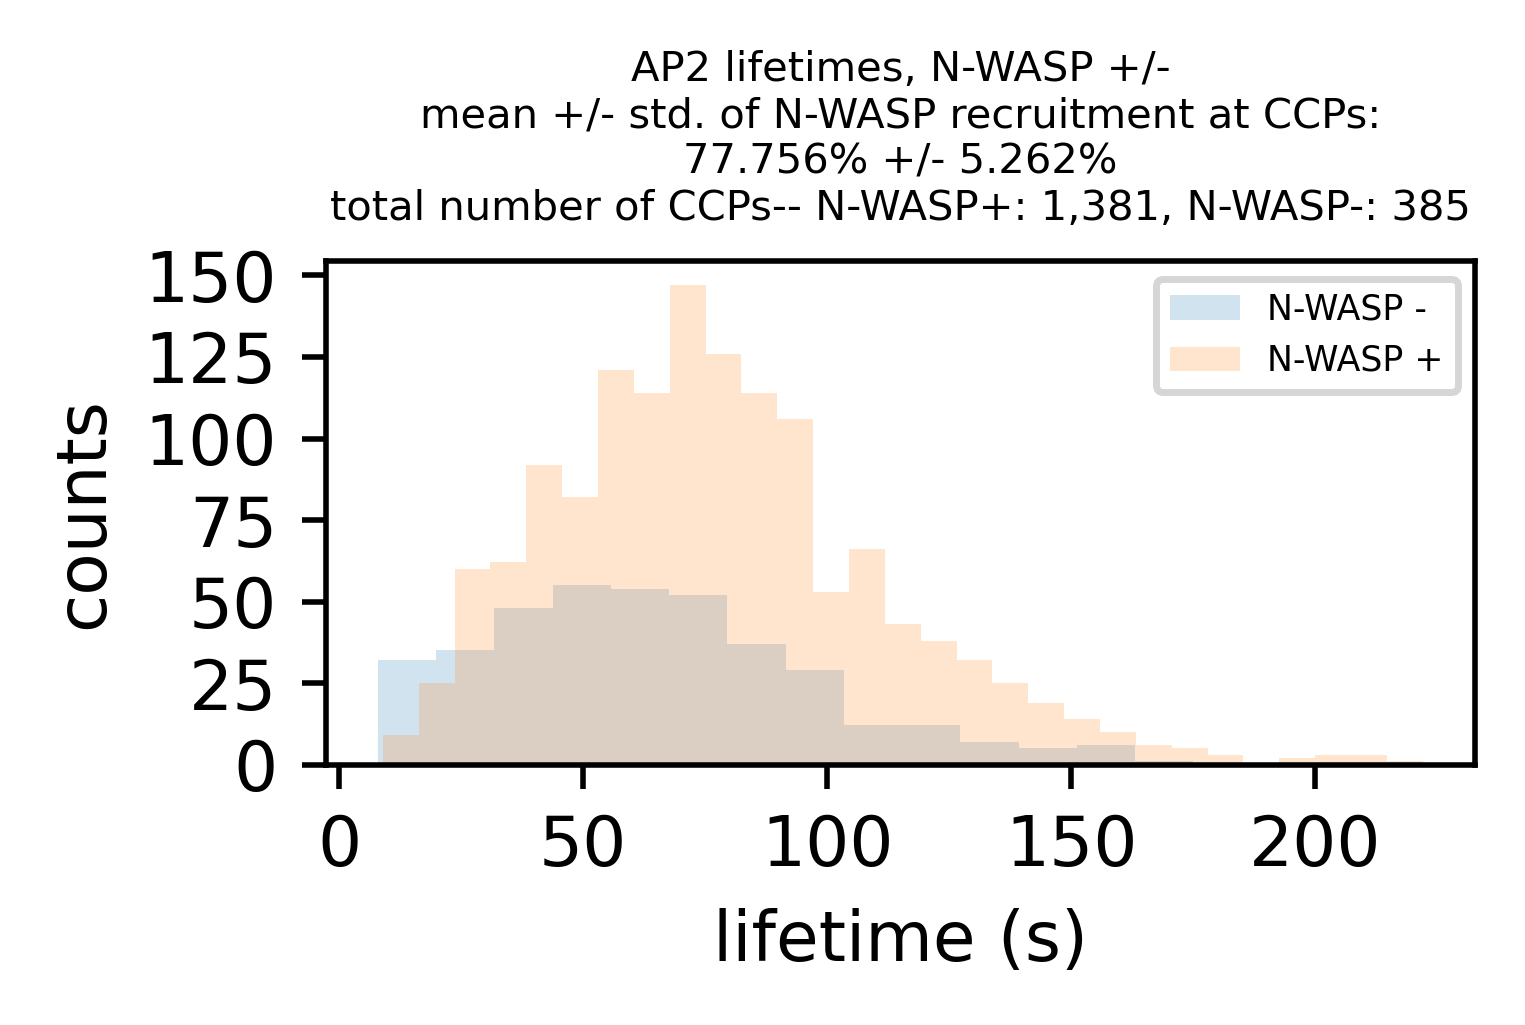

In [44]:
Image(filename=unique_user_saved_outputs+'/plots/ap2lifetimes_plusminus_nwasp_histogram_counts.png', height=500, width=500)

In [45]:
%%capture

plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(3,2)
plt.hist(ap2_lifetime_nwasp_negative, alpha=0.2, label='N-WASP -', weights=np.ones(len(ap2_lifetime_nwasp_negative)) / len(ap2_lifetime_nwasp_negative))
plt.hist(ap2_lifetime_nwasp_positive, alpha=0.2, label='N-WASP +',  weights=np.ones(len(ap2_lifetime_nwasp_positive)) / len(ap2_lifetime_nwasp_positive))
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('frequency density')
plt.title('AP2 lifetimes, N-WASP +/-'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs- N-WASP+: ' + "{:,}".format(len(ap2_lifetime_nwasp_positive)) + 
          ', N-WASP-: ' + "{:,}".format(len(ap2_lifetime_nwasp_negative)))
plt.legend()
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/ap2lifetimes_plusminus_nwasp_histogram_density.png', bbox_inches="tight")

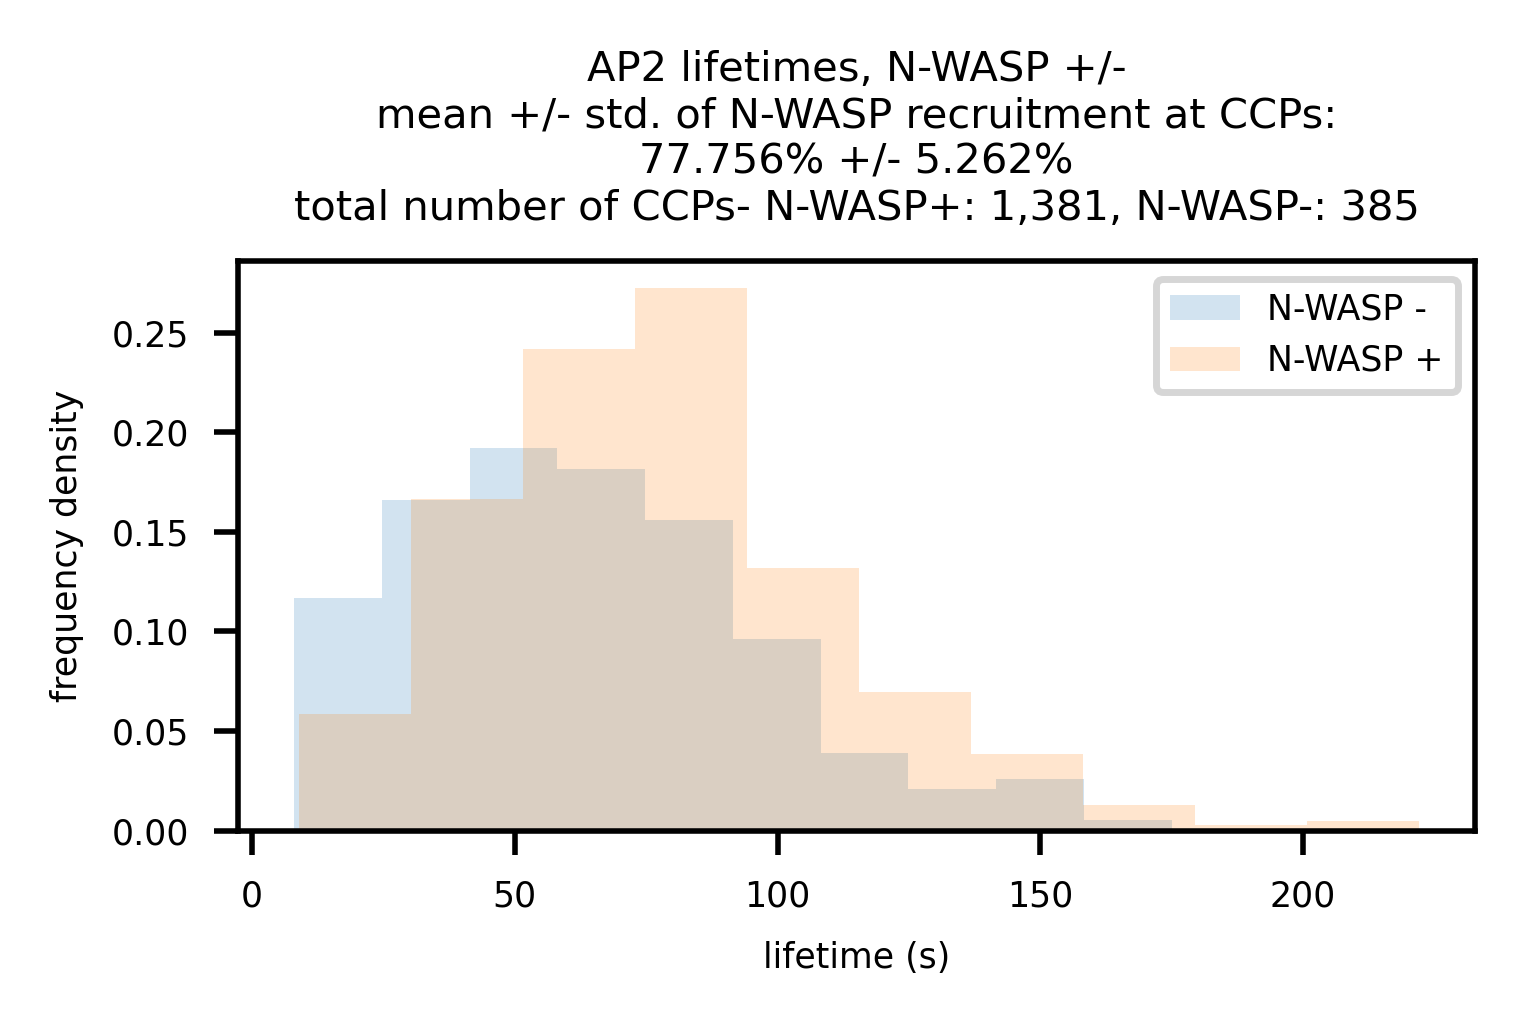

In [46]:
Image(filename=unique_user_saved_outputs+'/plots/ap2lifetimes_plusminus_nwasp_histogram_density.png', height=500, width=500)

# CCP lifetimes (AP2 initiation to DNM2 peak) of N-WASP+/- events

In [47]:
%%capture

plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(3,2)
plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_negative, alpha=0.2, label='N-WASP -', bins='auto')
plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_positive, alpha=0.2, label='N-WASP +', bins='auto')
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('counts')
plt.title('CCP lifetimes, N-WASP +/-'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs- N-WASP+: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_positive)) + 
          ', N-WASP-: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_negative)))
plt.legend()
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/ccplifetimes_plusminus_nwasp_histogram_counts.png', bbox_inches="tight")

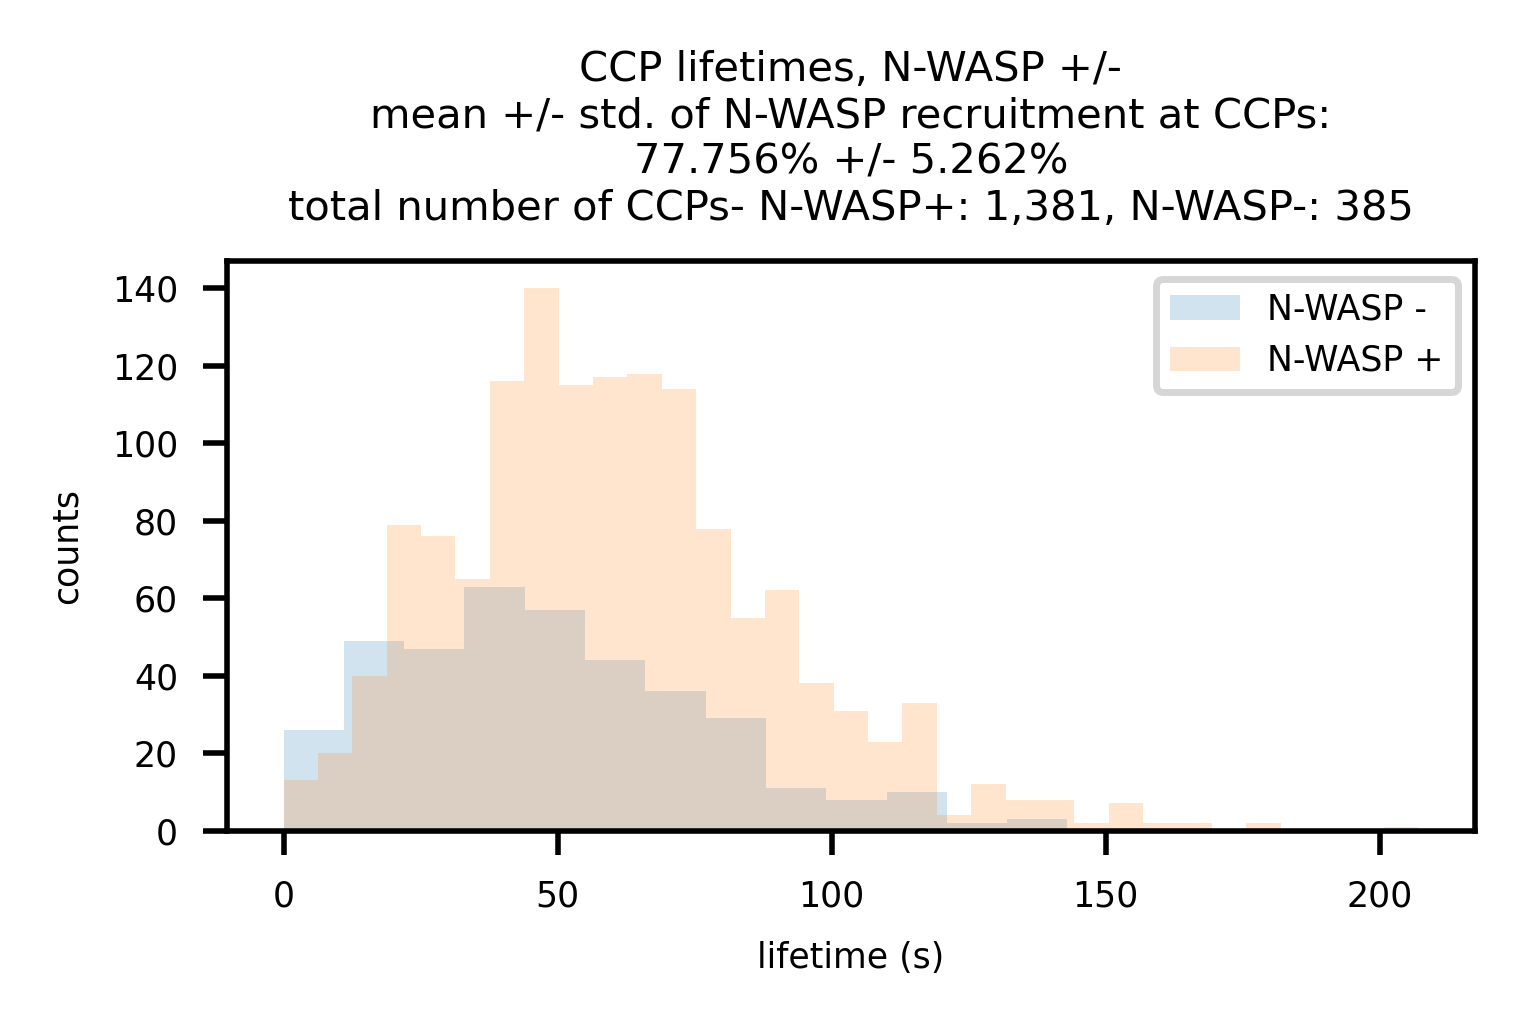

In [48]:
Image(filename=unique_user_saved_outputs+'/plots/ccplifetimes_plusminus_nwasp_histogram_counts.png', height=500, width=500)

In [49]:
%%capture

plt.rcParams['figure.dpi']=500
plt.rcParams['figure.figsize']=(3,2)
plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_negative, alpha=0.2, label='N-WASP -', weights=np.ones(len(time_ap2_appearance_to_dnm2_peak_nwasp_negative)) / len(time_ap2_appearance_to_dnm2_peak_nwasp_negative))
plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_positive, alpha=0.2, label='N-WASP +', weights=np.ones(len(time_ap2_appearance_to_dnm2_peak_nwasp_positive)) / len(time_ap2_appearance_to_dnm2_peak_nwasp_positive))
plt.rcParams.update({'font.size': 5})
plt.xlabel('lifetime (s)')
plt.ylabel('frequency density')
plt.title('CCP lifetimes, N-WASP +/-'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs- N-WASP+: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_positive)) + 
          ', N-WASP-: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_negative)))
plt.legend()
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/extfig4d_ccplifetimes_plusminus_nwasp_histogram_density.png', bbox_inches="tight")

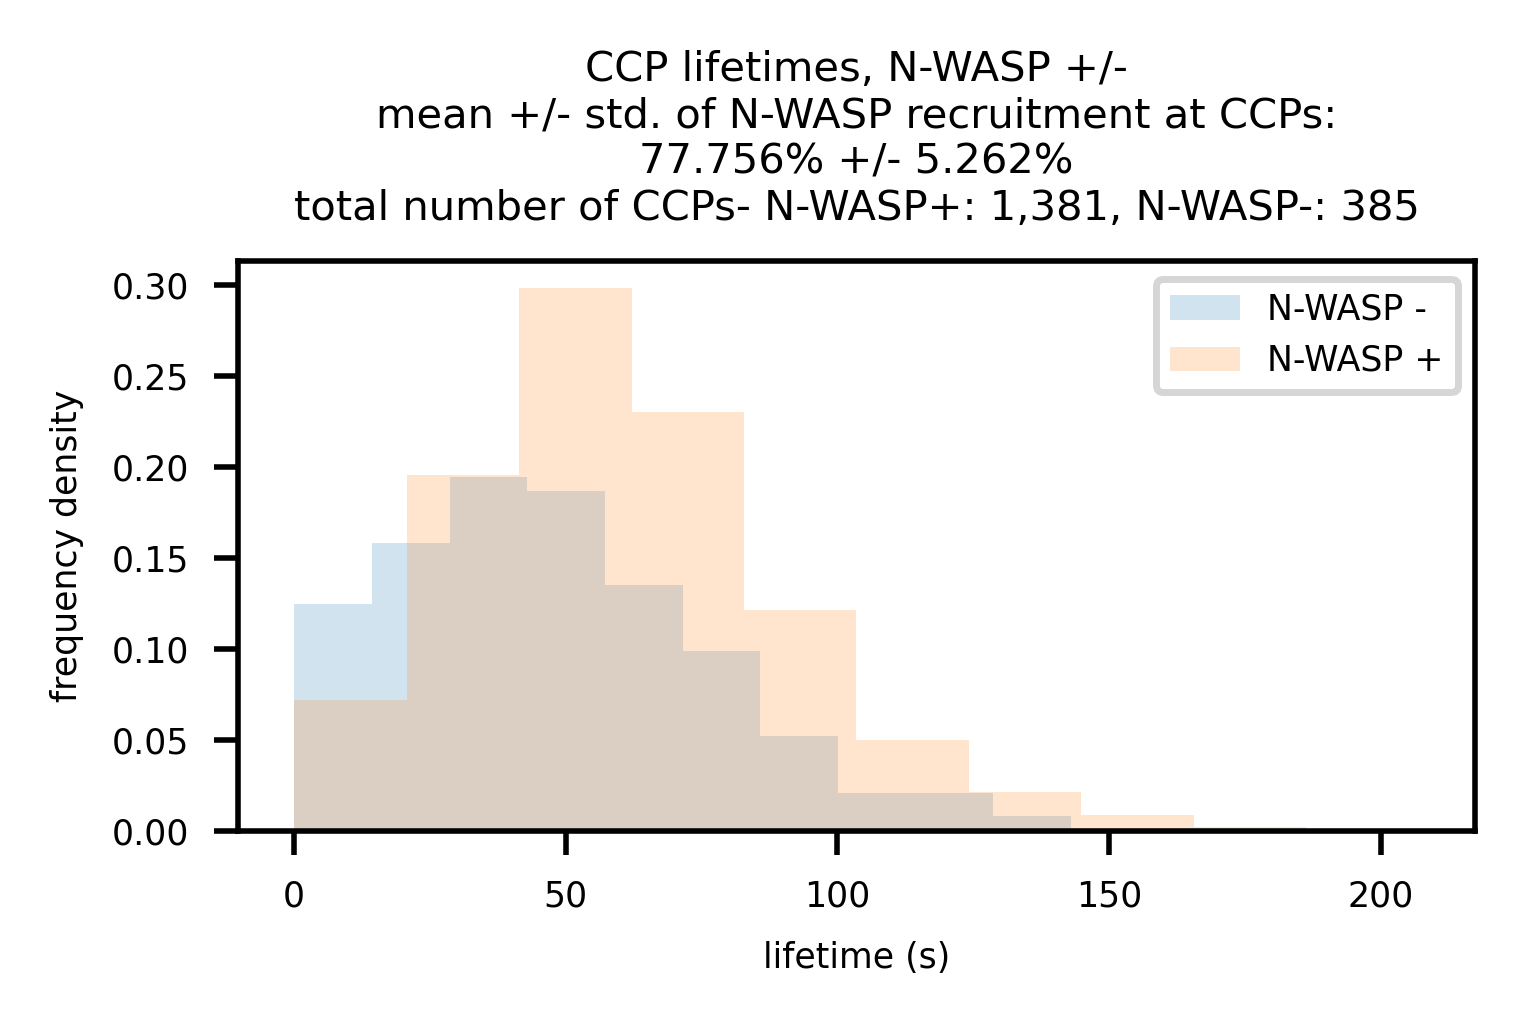

In [50]:
Image(filename=unique_user_saved_outputs+'/plots/extfig4d_ccplifetimes_plusminus_nwasp_histogram_density.png', height=500, width=500)

# histogram of N-WASP lifetimes

In [51]:
%%capture

plt.style.use('default')

plt.rcParams["figure.dpi"]=500
plt.rcParams["figure.figsize"]=(5,4)

plt.hist(time_nwasp_appearance_to_dnm2_peak_nwasp_positive,
         alpha=1,
         label='N-WASP lifetime',
         color='blue',
         weights=np.ones(len(time_nwasp_appearance_to_dnm2_peak_nwasp_positive)) / len(nwasp_lifetime_nwasp_positive))
plt.legend(loc='upper right', framealpha=1)
plt.xlabel('time (s)')
plt.ylabel('frequency density')
plt.title('N-WASP+ events'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n ' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs-- N-WASP+: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_positive)))
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/exfig4b_nwasp_lifetimes.png', bbox_inches='tight')

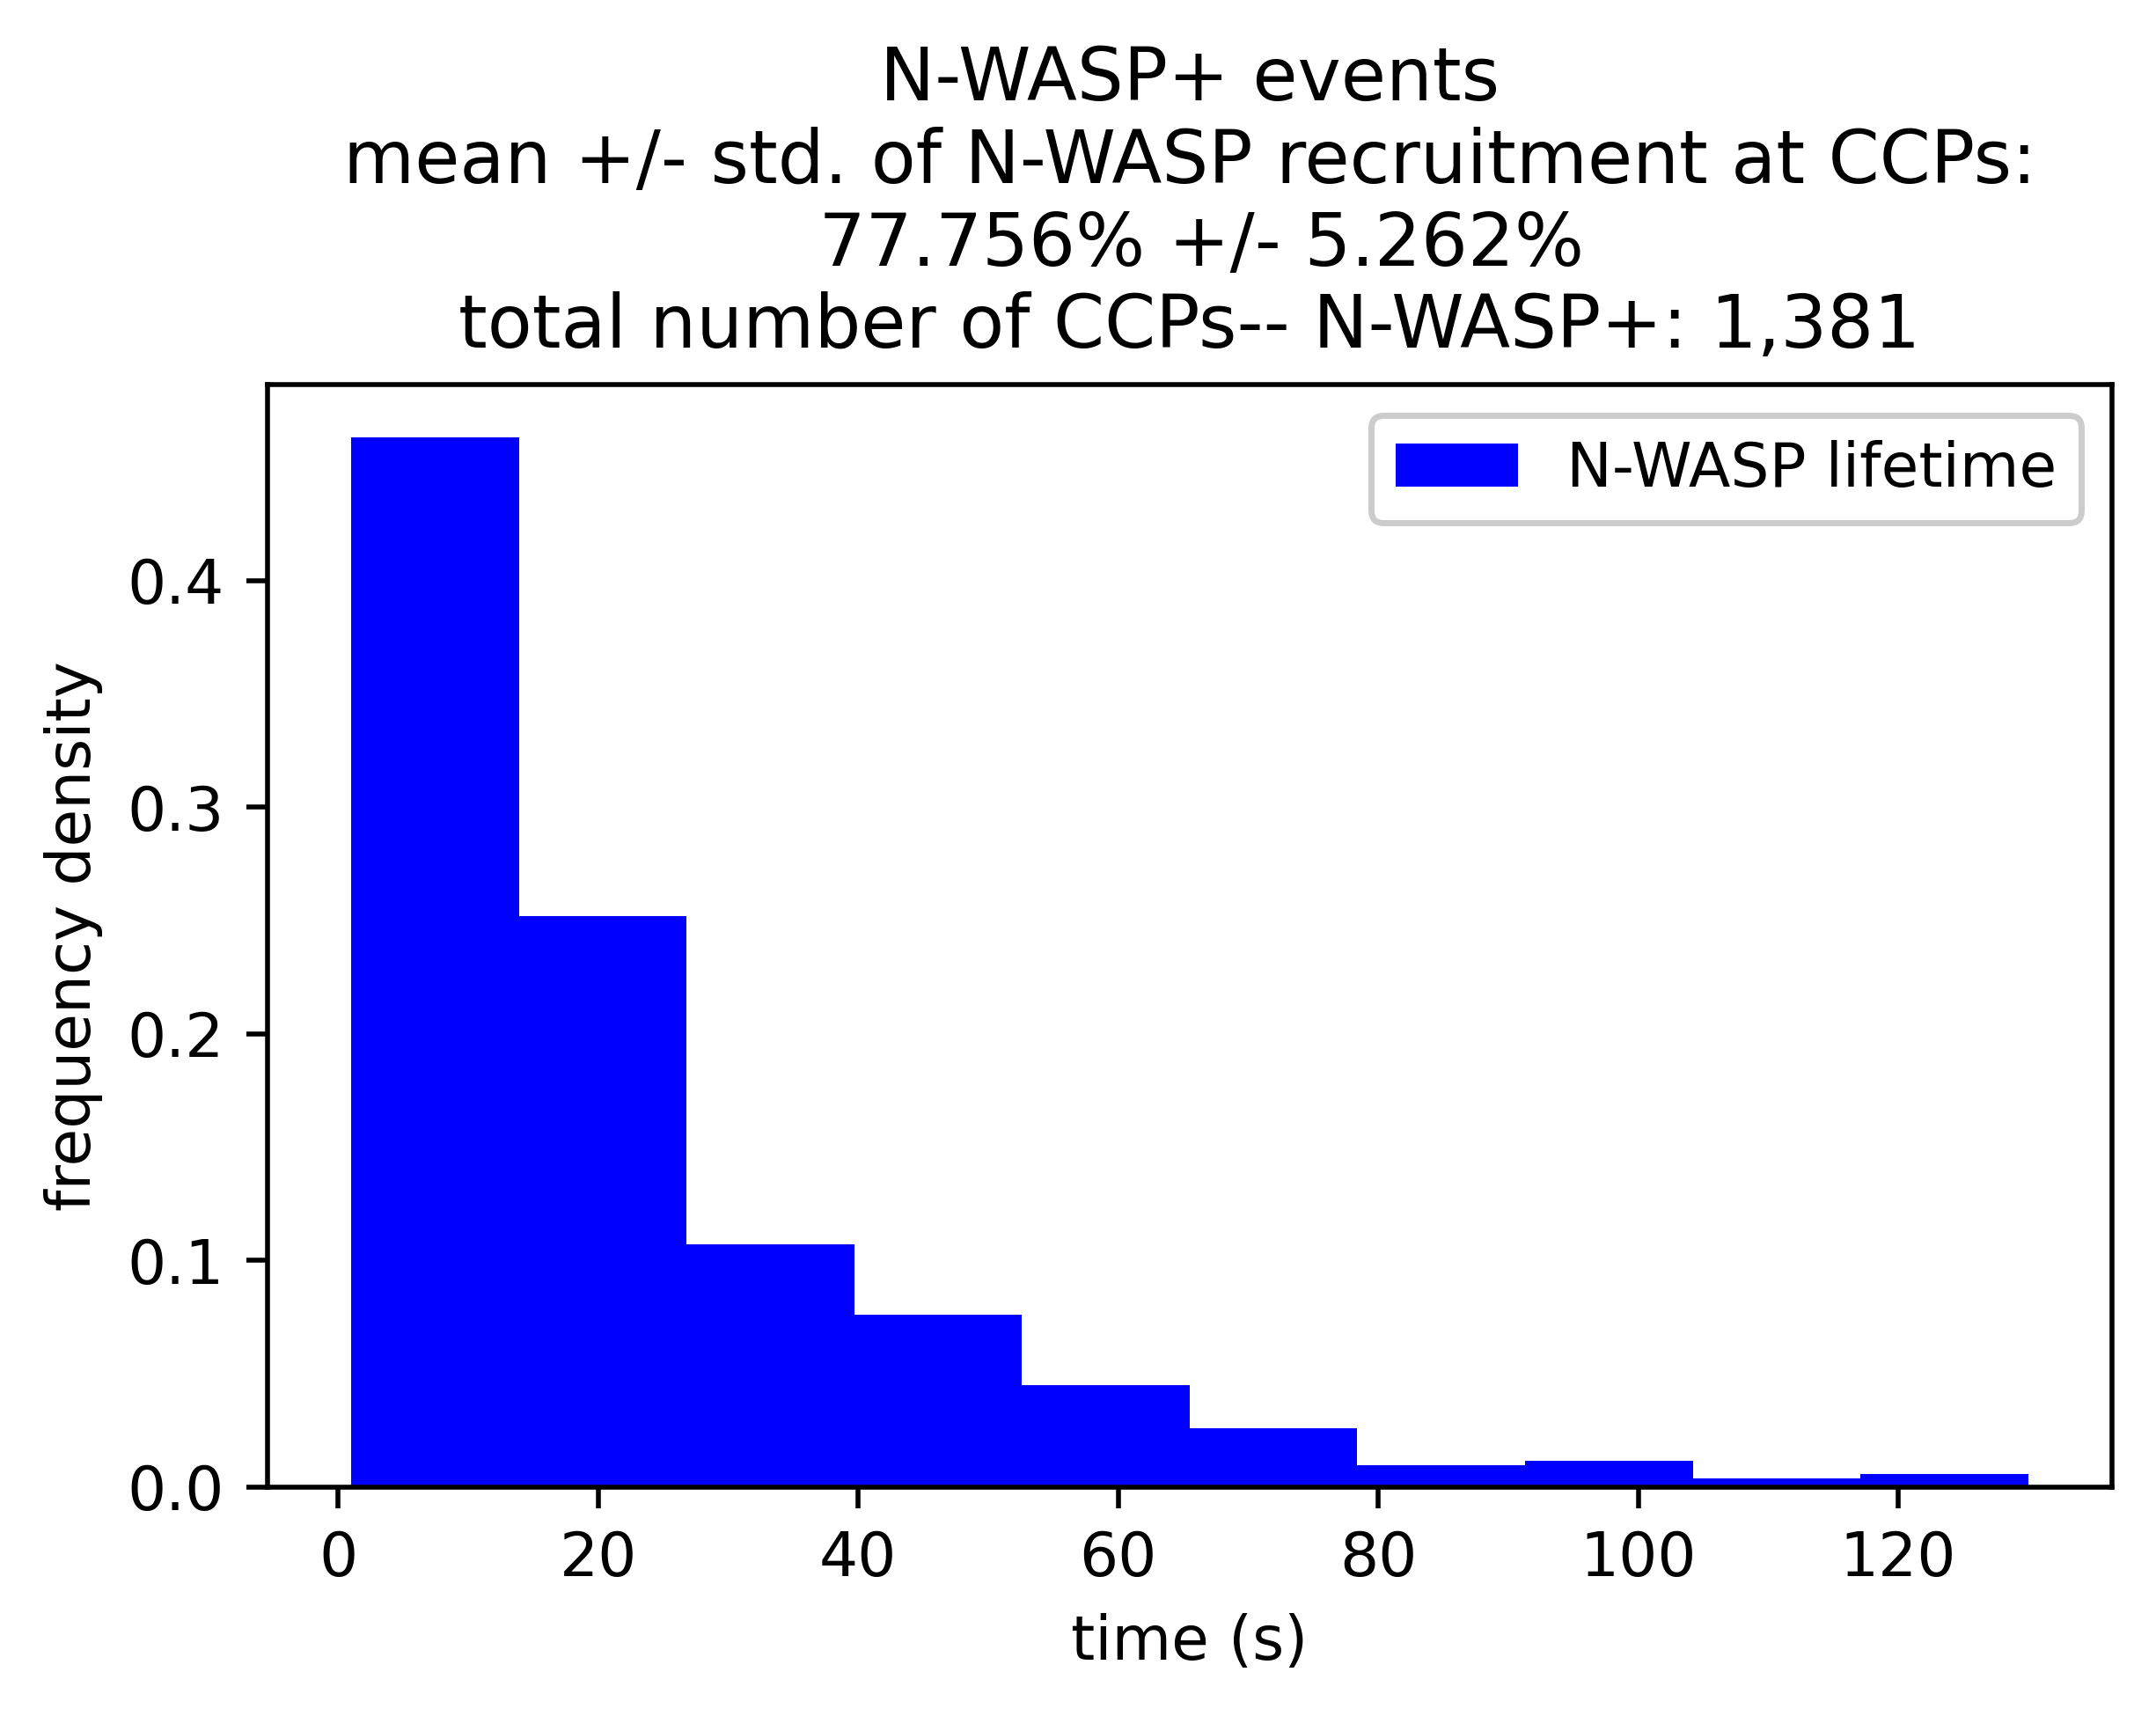

In [52]:
Image(filename=unique_user_saved_outputs+'/plots/exfig4b_nwasp_lifetimes.png', height=500, width=500)

# ECDF of AP2, CCP, and N-WASP lifetimes, merged view

In [53]:
%%capture

plt.style.use('default')

plt.rcParams["figure.dpi"]=500
plt.rcParams["figure.figsize"]=(7,4)


plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_negative,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP-, CCP lifetime',
         color='blue',
         linestyle='dashed')
plt.hist(time_ap2_appearance_to_dnm2_peak_nwasp_positive,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP+, CCP lifetime',
         color='orange',
         linestyle='dashed')
plt.hist(ap2_lifetime_nwasp_negative,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP-, AP2 lifetime',
         color='blue',
         linewidth=3)
plt.hist(ap2_lifetime_nwasp_positive,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP+, AP2 lifetime',
         color='orange',
         linewidth=3)
plt.hist(time_nwasp_appearance_to_dnm2_peak_nwasp_positive,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP initiation-to-scission',
         color='pink',
         linewidth=3,
         linestyle='dashed')
plt.hist(nwasp_lifetime_nwasp_positive,
         bins='auto',
         alpha=1,
         density=True,
         histtype='step', 
         cumulative=True,
         label='N-WASP lifetime',
         color='pink',
         linewidth=3)
plt.legend(loc='lower right', framealpha=1)
plt.xlabel('time (s)')
plt.ylabel('cumulative frequency')
plt.title('CCP events'+
          '\nmean +/- std. of N-WASP recruitment at CCPs:\n ' + 
          str(np.around(100*np.mean(merged_results['fraction_nwasp_positive']),3)) + '% +/- ' +
          str(np.around(100*np.std(merged_results['fraction_nwasp_positive']),3)) + '%' + 
          '\ntotal number of CCPs-- N-WASP+: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_positive)) + 
          ', N-WASP-: ' + "{:,}".format(len(time_ap2_appearance_to_dnm2_peak_nwasp_negative)))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/merged_lifetimes_nwasp_ecdfs.png', bbox_inches='tight')

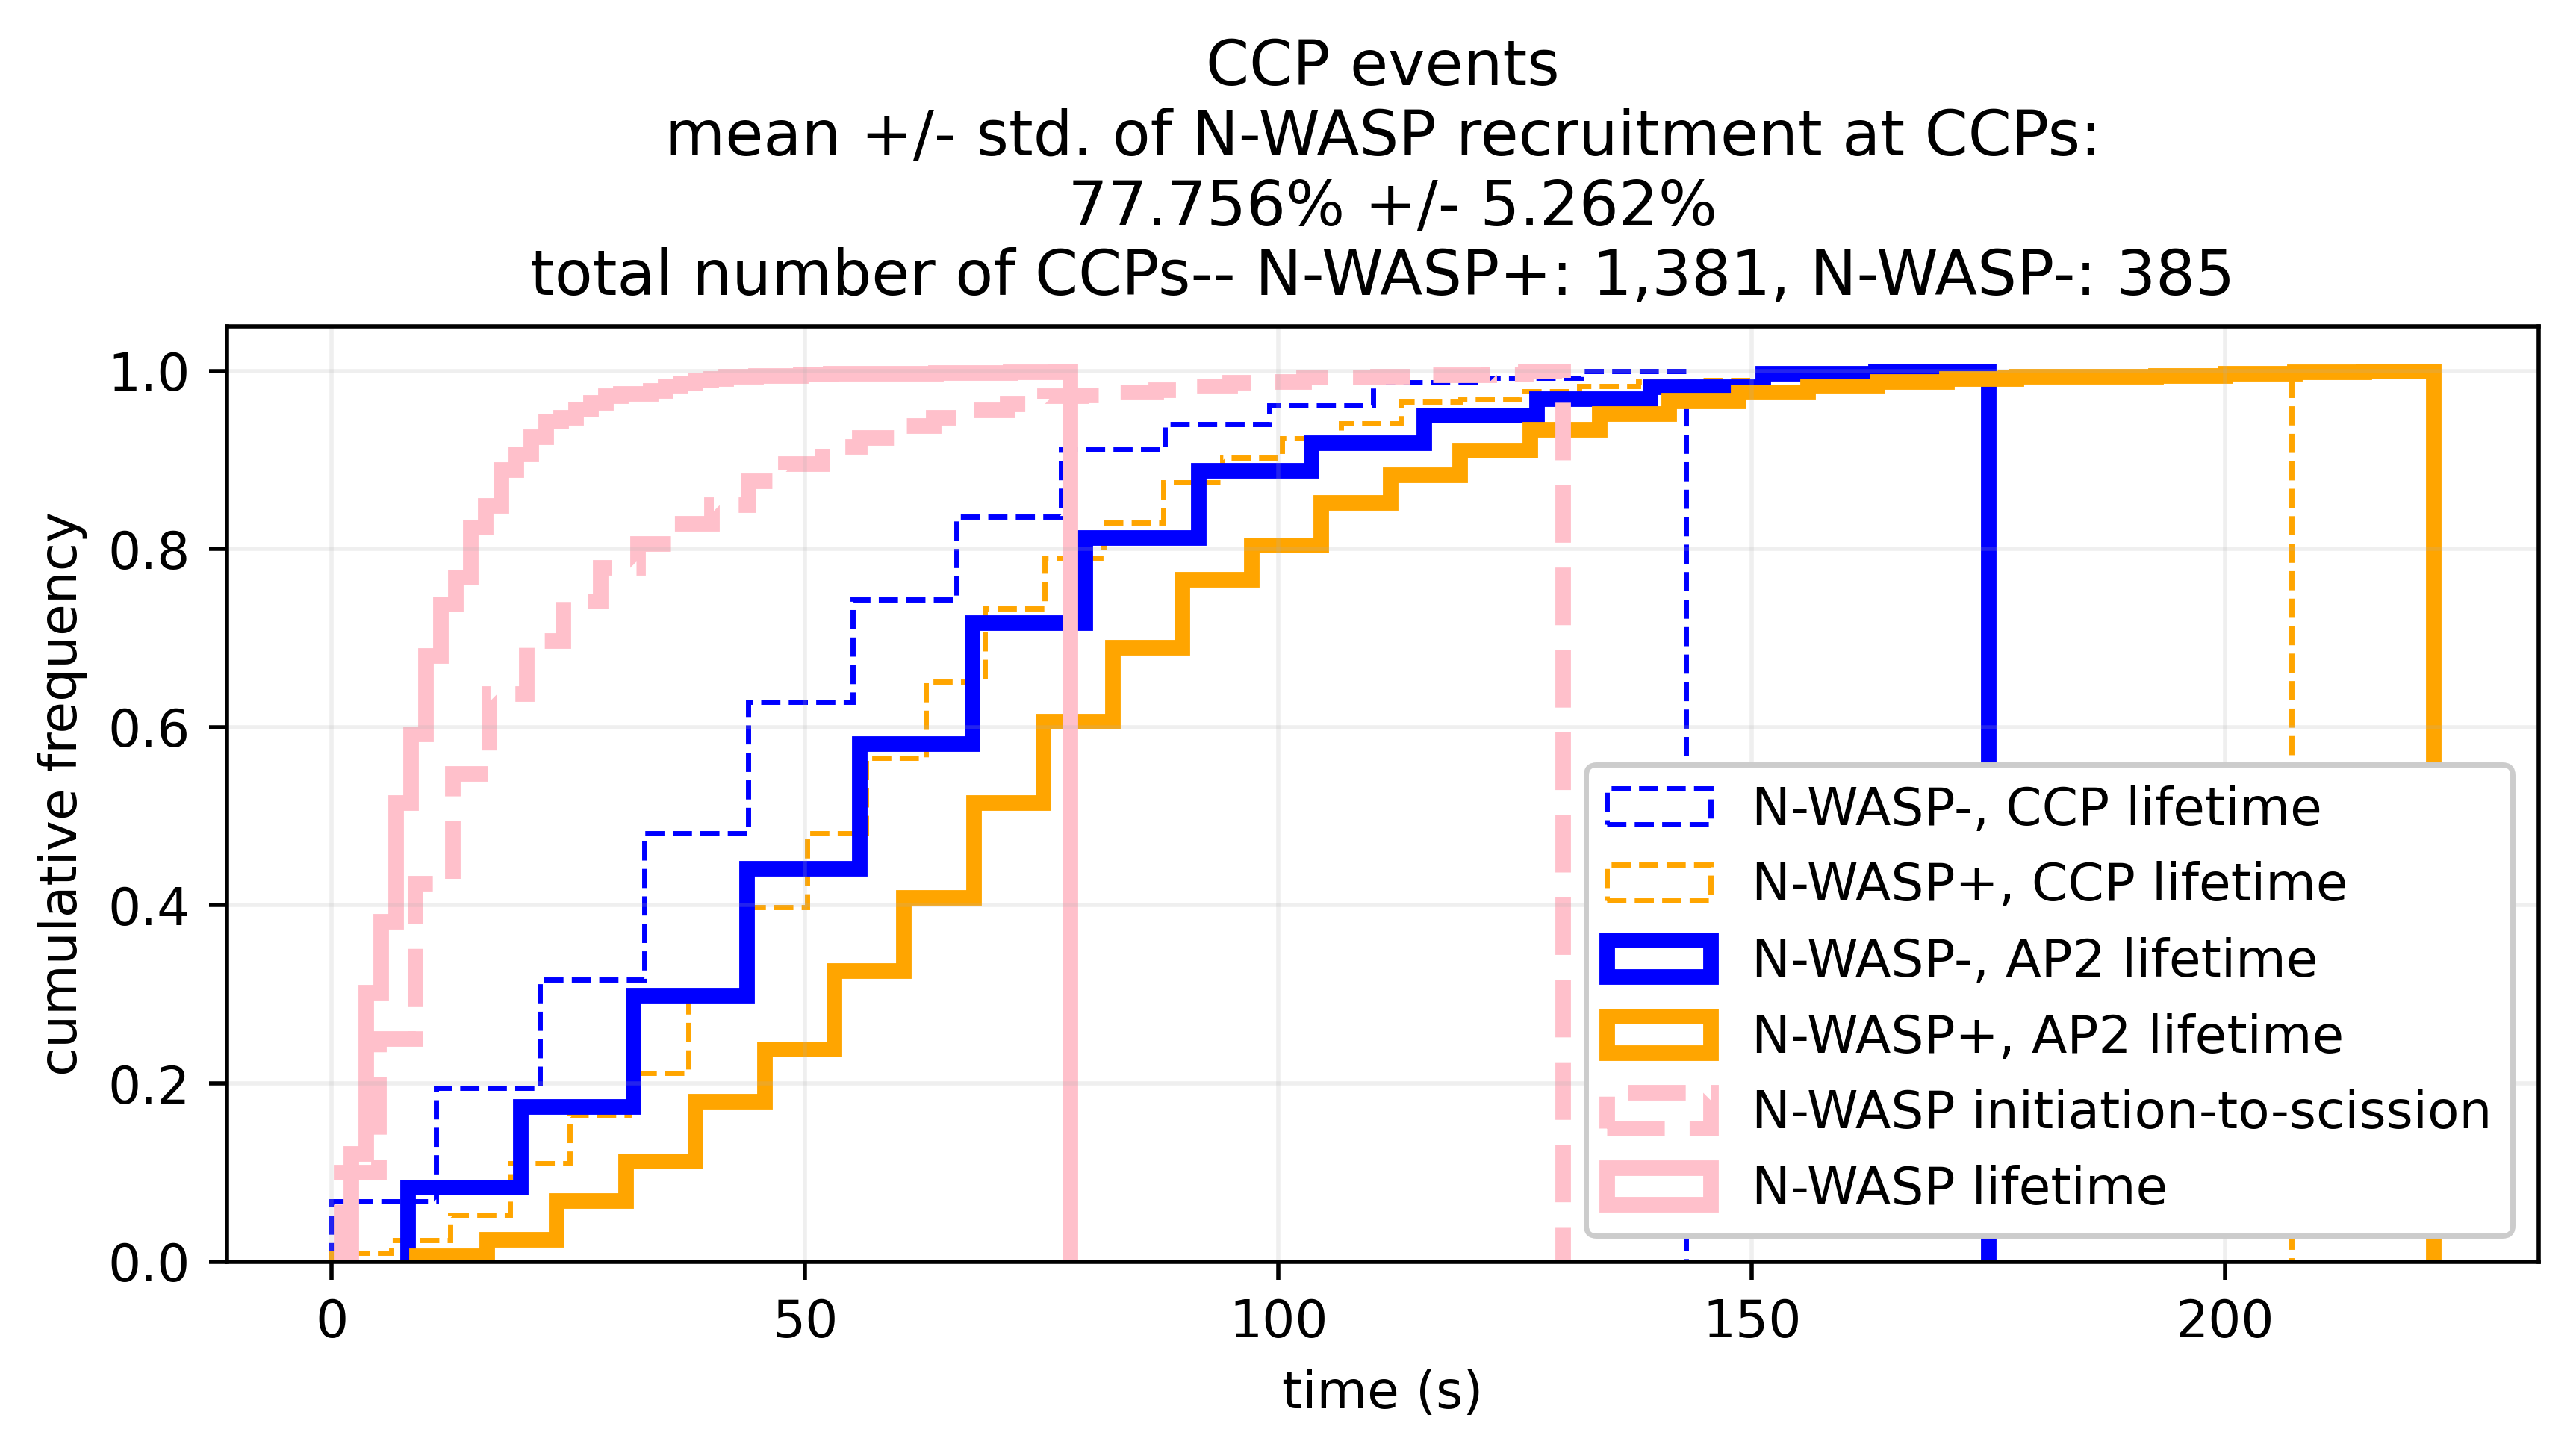

In [54]:
Image(filename=unique_user_saved_outputs+'/plots/merged_lifetimes_nwasp_ecdfs.png', height=500, width=500)

# merge amplitudes of different channels

In [66]:
channel_amplitudes_nwasp_negative = []
for i in range(len(merged_results['ch0_vectors_nwasp_negative'])):
    channel_amplitudes_nwasp_negative.append([merged_results['ch0_vectors_nwasp_negative'][i],
                                              merged_results['ch1_vectors_nwasp_negative'][i],
                                              merged_results['channel_0_1_separations_nwasp_negative'][i]])
    
channel_amplitudes_nwasp_positive = []
for i in range(len(merged_results['ch0_vectors_nwasp_positive'])):
    channel_amplitudes_nwasp_positive.append([merged_results['ch0_vectors_nwasp_positive'][i],
                                              merged_results['ch1_vectors_nwasp_positive'][i],
                                              merged_results['ch2_vectors_nwasp_positive'][i],
                                              merged_results['channel_0_1_separations_nwasp_positive'][i],
                                              merged_results['channel_0_2_separations_nwasp_positive'][i],
                                              merged_results['channel_1_2_separations_nwasp_positive'][i]])

# cohorts of N-WASP- CCPs

In [56]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))


cohorts = [[min(ap2_lifetime_nwasp_negative),40],[40,60],[60,80],[80,max(ap2_lifetime_nwasp_negative)]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_nwasp_negative[:-1], 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1], 
                                                                         [], 
                                                                         ['AP2', 'DNM2'],
                                                                         ['m', 'g'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_nwasp_negative)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 305
text_bounds_y = 320

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_negative)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_negative)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_negative)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('N-WASP- CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,330])  

plt.savefig(unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_nwaspminusccps_cohorts_centered_zero.png', bbox_inches='tight')

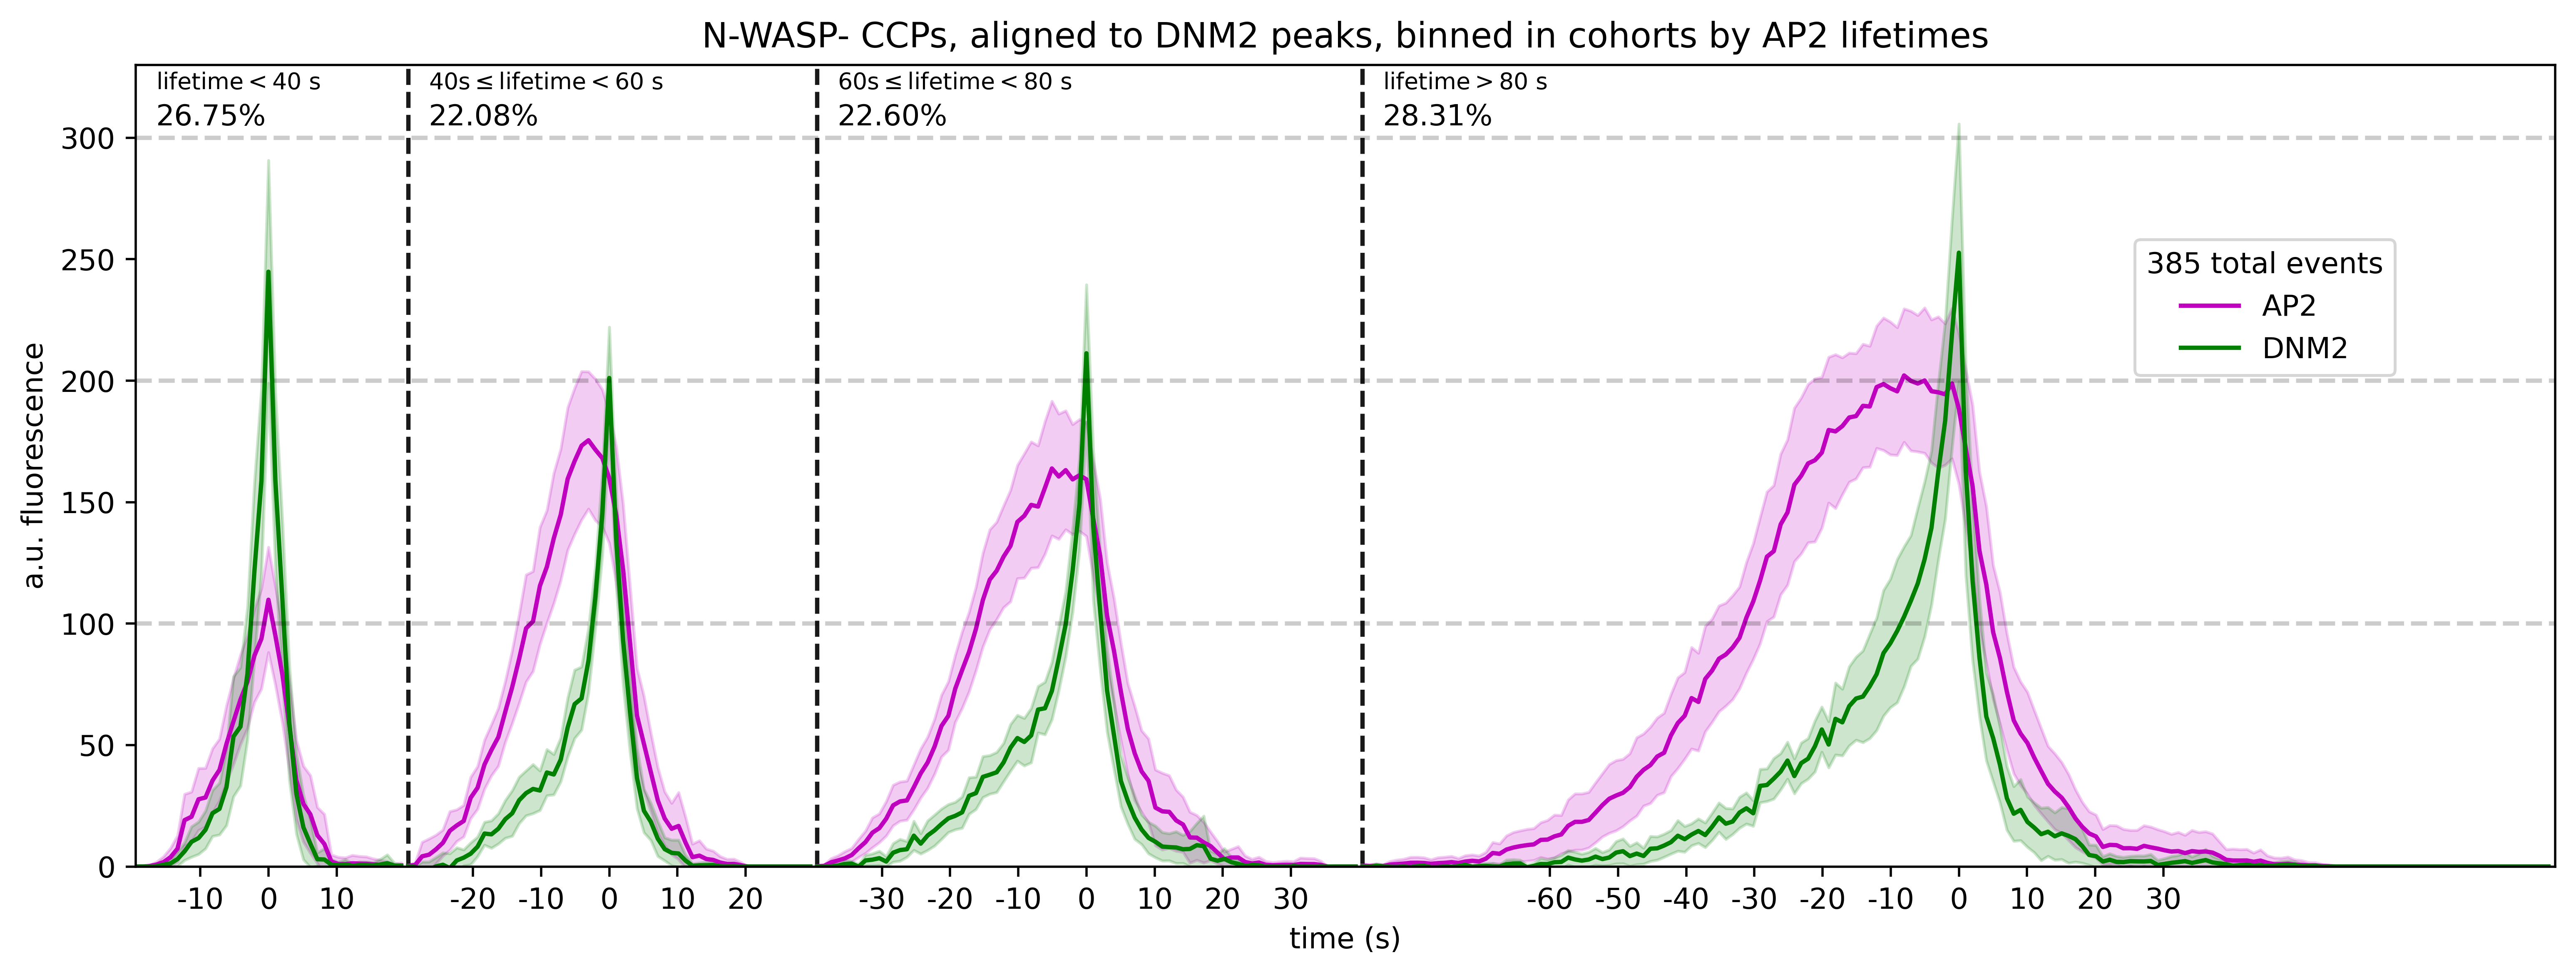

In [57]:
Image(filename=unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_nwaspminusccps_cohorts_centered_zero.png', height=500, width=500)

# cohorts of N-WASP+ CCPs

In [58]:
max(ap2_lifetime_nwasp_positive)

222

In [59]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))
# axes_separation = axes.twinx()

cohorts = [[min(ap2_lifetime_nwasp_positive),40],[40,60],[60,80],[80,193]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_nwasp_positive, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [], 
                                                                         ['AP2', 'DNM2', 'nwasp'],
                                                                         ['m', 'g', 'b'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_nwasp_positive)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 310
text_bounds_y = 330

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_positive)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_positive)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_nwasp_positive)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('N-WASP+ CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,370])  
# axes_separation.set_ylim([0,.3])
# plt.tight_layout()   
plt.savefig(unique_user_saved_outputs+'/plots/extfig4c_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_centered_zero.png', bbox_inches='tight')

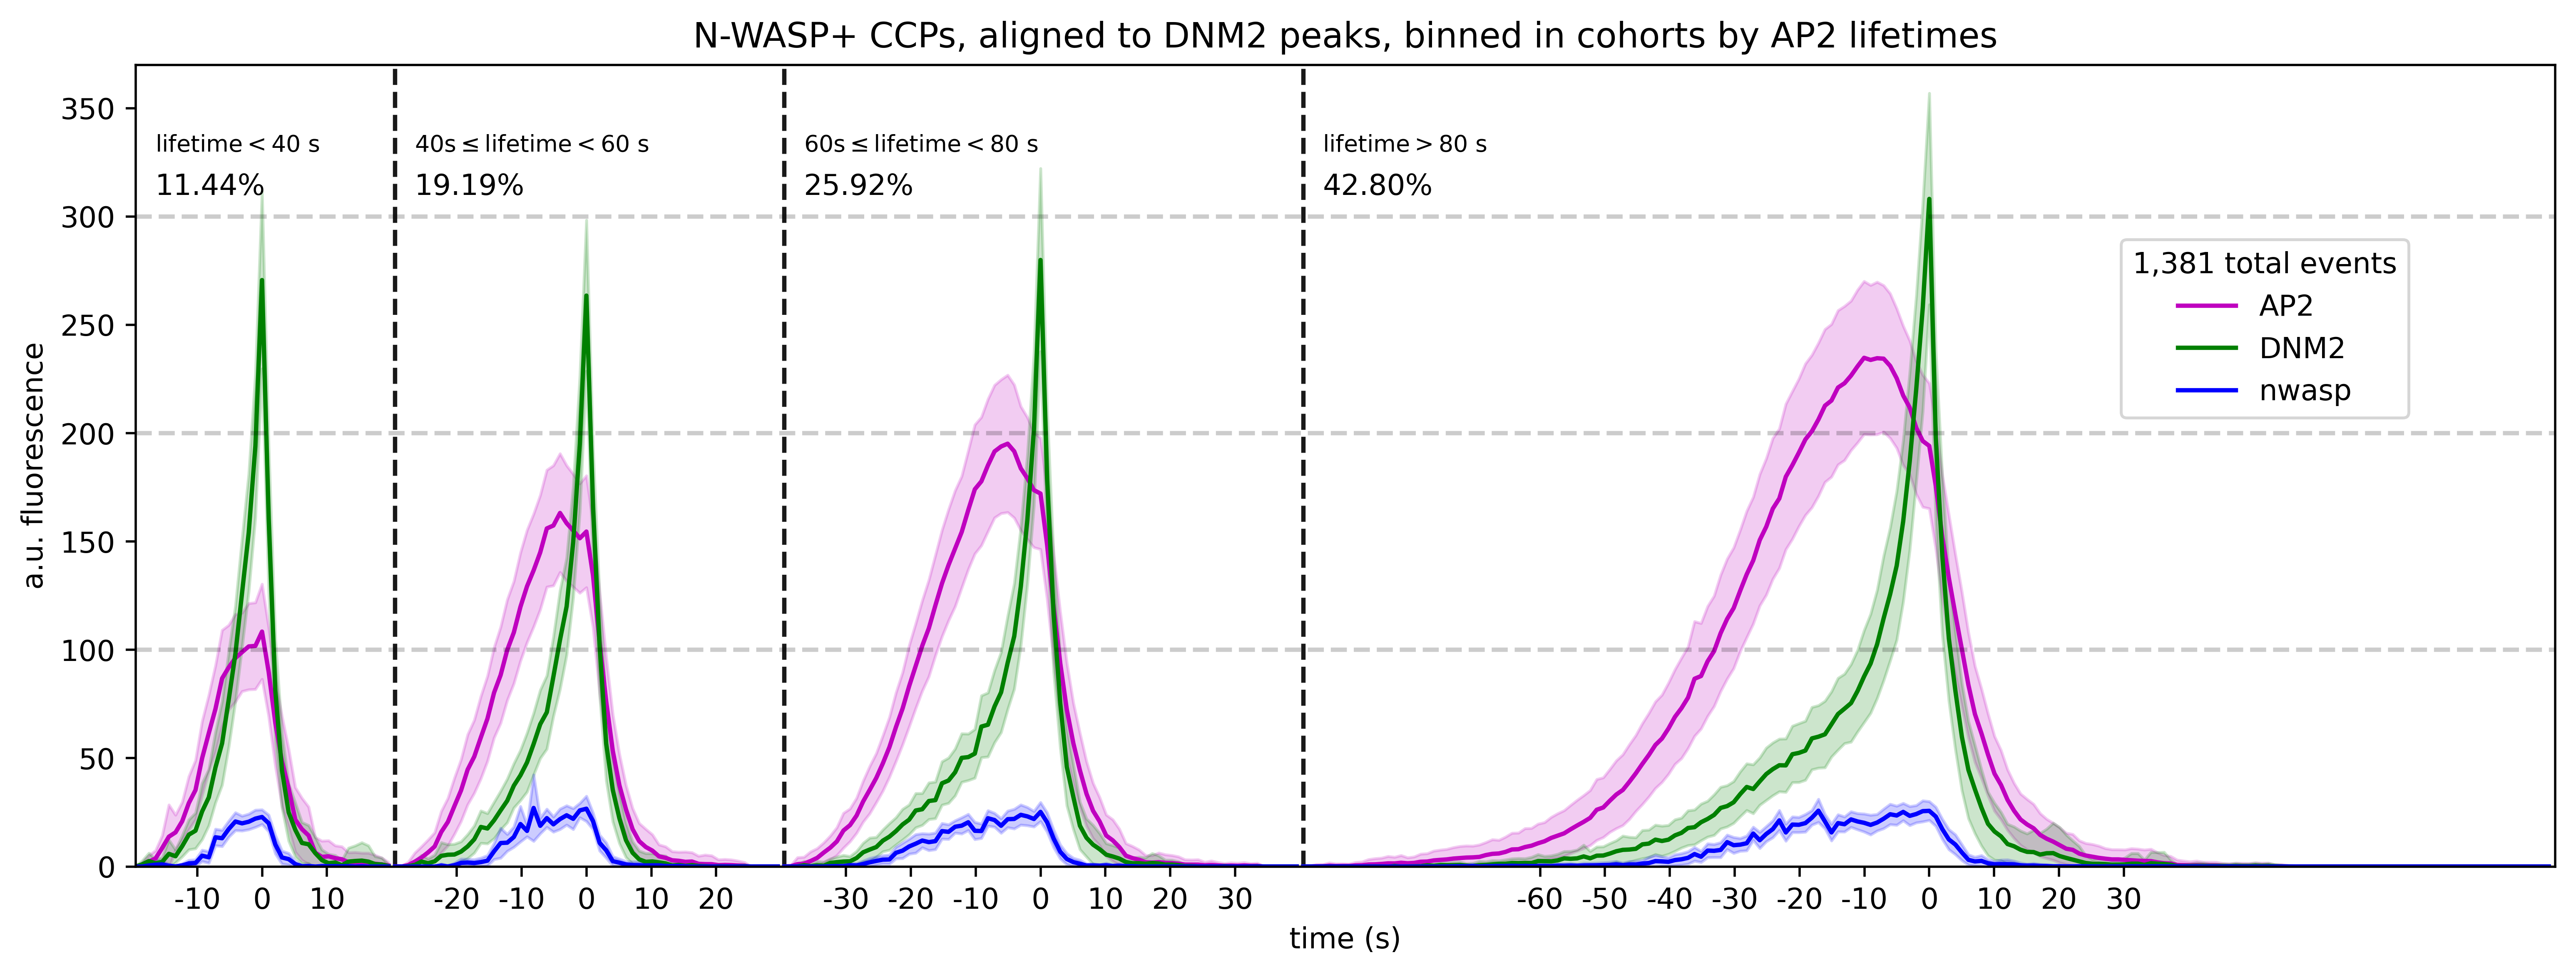

In [60]:
Image(filename=unique_user_saved_outputs+'/plots/extfig4c_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_centered_zero.png', height=500, width=500)

# comparing N-WASP+/- aligned intensities

In [61]:
%%capture

plt.style.use('default')
plt.rcParams['axes.spines.right'] = True

fig, (axes_0, axes_1) = plt.subplots(2, 1, dpi=500, figsize=(6,7), gridspec_kw=dict(height_ratios=[1,1]))



cohorts = [[min(ap2_lifetime_nwasp_negative), max(ap2_lifetime_nwasp_negative)]]

offsets, num_in_cohort, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0], 
                                                                         channel_amplitudes_nwasp_negative, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1], 
                                                                         [], 
                                                                         ['AP2', 'DNM2'],
                                                                         ['m', 'g'],
                                                                         line_cutoff_index=[],
                                                                         line_cutoff_regions=[[], [], []],
                                                                         horizontal_shift_index=[0, 1], 
                                                                         horizontal_shift=[-87, -87])                                                                           


cohorts = [[min(ap2_lifetime_nwasp_positive), max(ap2_lifetime_nwasp_positive)]]

_, _, max_dnm2_cohort_indices_1 = display_tracks.plot_separated_cohorts([axes_1], 
                                                                         channel_amplitudes_nwasp_positive, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [], 
                                                                         ['AP2', 'DNM2', 'N-WASP'],
                                                                         ['m', 'g', 'b'],
                                                                         line_cutoff_index=[],
                                                                         line_cutoff_regions=[[], [], [], [], []],
                                                                         horizontal_shift_index=[0, 1, 2], 
                                                                         horizontal_shift=[-110, -110, -110])



lines_0, labels_0 = axes_1.get_legend_handles_labels()
# lines_1, labels_1 = axes_separation_0.get_legend_handles_labels()

axes_0.legend(lines_0, labels_0, 
            loc='upper right')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes_0.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)
    axes_1.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

axes_1.set_xlabel('time (s)') 

# axes_separation_0.set_ylim([0,0.5])
# axes_separation_1.set_ylim([0,0.5])

axes_1.set_yticks([0,100,200,300, 400], minor=False)
axes_1.set_yticklabels([0,100,200,300, 400], minor=False)
axes_0.set_yticks([0,100,200,300,400, 500], minor=False)
axes_0.set_yticklabels([0,100,200,300,400, 500], minor=False)

# axes_separation_1.set_yticks([0, 0.1, 0.2, 0.3, 0.4], minor=False)
# axes_separation_1.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], minor=False)
# axes_separation_0.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)
# axes_separation_0.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)

plt.setp(axes_0.get_xticklabels(), visible=False)
yticks = axes_1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)

# axes_0.axvline(20, color='black', linewidth=5, linestyle=)
# axes_1.axvline(20, color='black', linewidth=5, linestyle='--')

axes_0.text(-36,0, 'a.u. fluorescence', rotation="vertical", va="center", fontsize=10);
# axes_0.text(24,0, 'separation (microns)', rotation=270, va="center", fontsize=10);

axes_1.set_xticks(0.5+np.array([-20, -10, 0, 10]), minor=False)
axes_1.set_xticklabels([-20, -10, 0, 10], minor=False)

axes_0.set_title('cohorts of N-WASP+/- events')
axes_0.set_xlim([-30, 20]) 
axes_1.set_xlim([-30, 20]) 
axes_0.set_ylim([0,400])
axes_1.set_ylim([0,400])
plt.savefig(unique_user_saved_outputs+'/plots/extfig4e_all_overlaid_cohorts_stacked_no_distance_nwasp.png', bbox_inches='tight')

In [62]:
max_dnm2_cohort_indices_0, max_dnm2_cohort_indices_1

([87], [110])

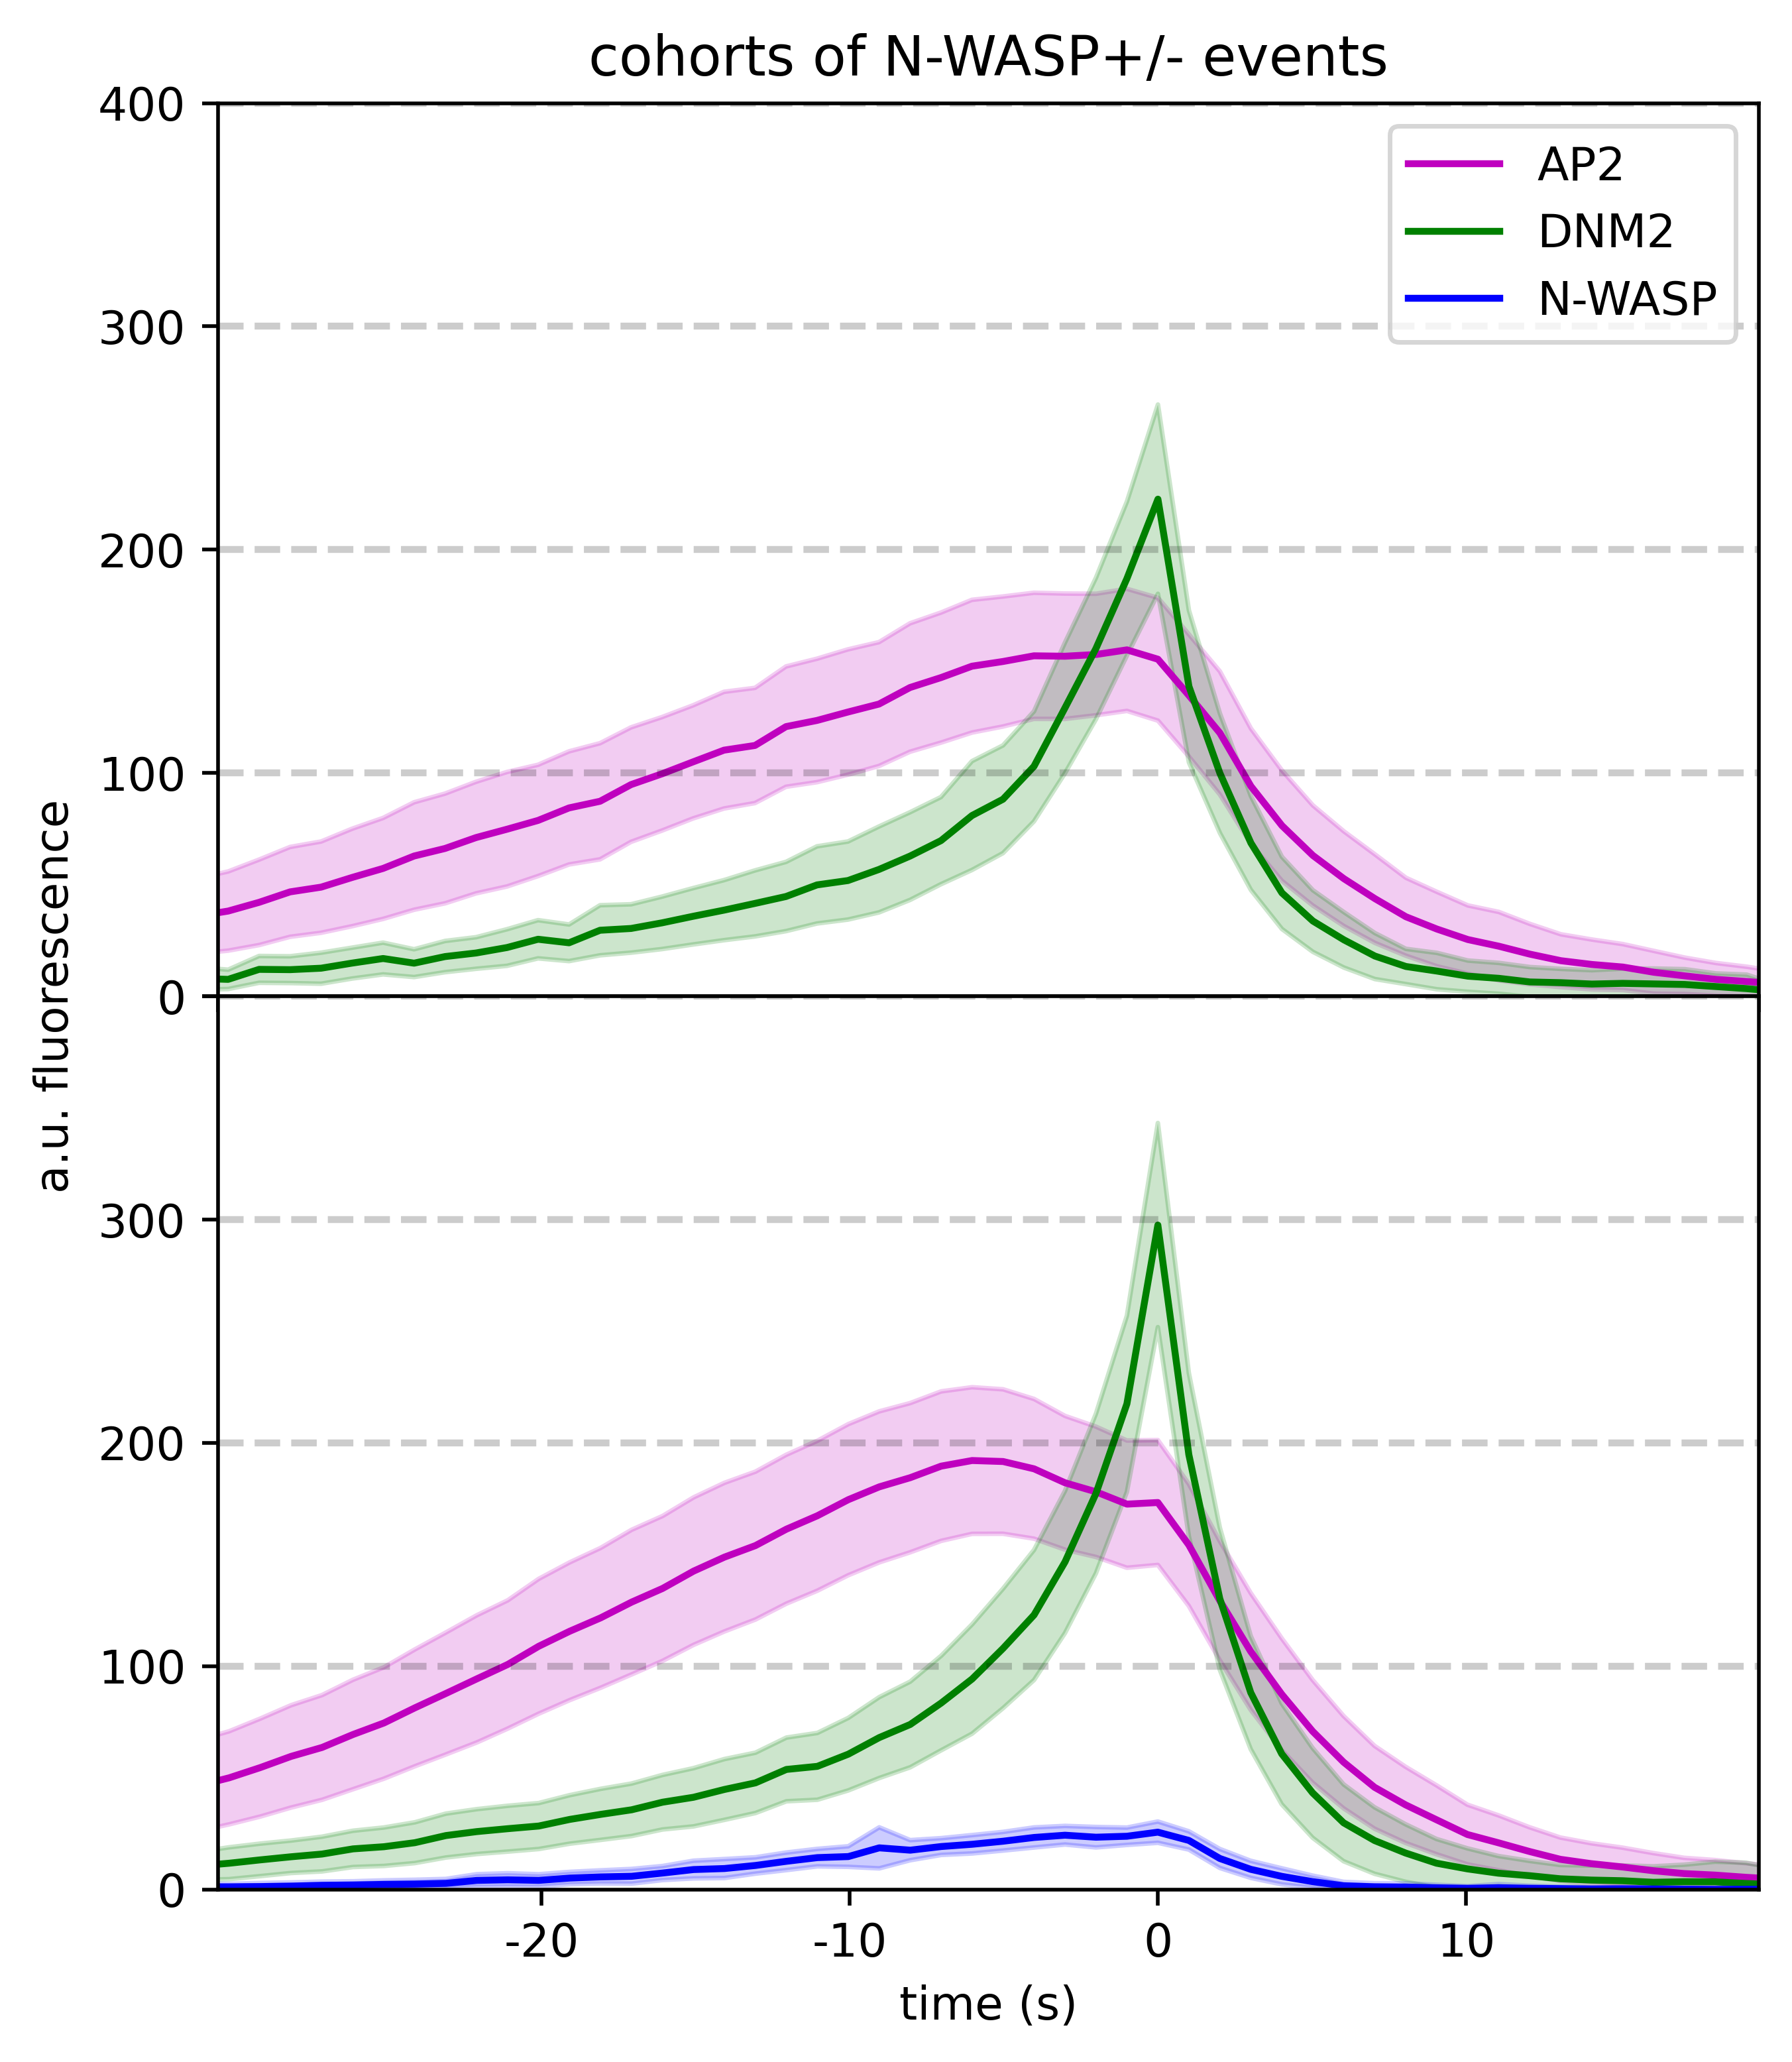

In [63]:
Image(filename=unique_user_saved_outputs+'/plots/extfig4e_all_overlaid_cohorts_stacked_no_distance_nwasp.png', height=500, width=500)

# N-WASP+ cohort with AP2/DNM2 and AP2/N-WASP separation

In [70]:
%%capture

plt.style.use('default')
plt.rcParams['axes.spines.right'] = False

fig, axes_0 = plt.subplots(1, 1, dpi=500, figsize=(7,5))
axes_separation_0 = axes_0.twinx()

cohorts = [[min(ap2_lifetime_nwasp_positive), max(ap2_lifetime_nwasp_positive)]]

_, _, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0, axes_separation_0], 
                                                                         channel_amplitudes_nwasp_positive, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [3, 4], 
                                                                         ['AP2', 'DNM2', 'N-WASP', 'AP2-DNM2', 'AP2-N-WASP'],
                                                                         ['m', 'g', 'b', 'g', 'b'],
                                                                         line_cutoff_index=[3, 4],
                                                                         line_cutoff_regions=[[], [], [], [[0, 110-10], [113, 150]], [[0, 110-10], [113, 150]]],
                                                                         horizontal_shift_index=[0, 1, 2, 3, 4], 
                                                                         horizontal_shift=[-110, -110, -110, -110, -110],
                                                                         norm_intensity=True)


                                                                        


lines_0, labels_0 = axes_0.get_legend_handles_labels()
lines_1, labels_1 = axes_separation_0.get_legend_handles_labels()

axes_0.legend(lines_0+lines_1, labels_0+labels_1, 
            loc='upper left')

y_lines = np.arange(0,1.25,0.25)

for i in range(1,len(y_lines)):
    
    axes_0.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

axes_0.set_xlabel('time (s)') 

axes_separation_0.set_ylim([0,1])


axes_0.set_yticks([0,0.25, 0.5, 0.75, 1], minor=False)
axes_0.set_yticklabels([0,0.25, 0.5, 0.75, 1], minor=False)


axes_separation_0.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], minor=False)
axes_separation_0.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], minor=False)

# plt.setp(axes_0.get_xticklabels(), visible=False)
yticks = axes_1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)

axes_0.axvline(11, color='black', linewidth=5, linestyle='--')

# axes_0.text(-31,0, 'a.u. fluorescence scaled to one', rotation="vertical", va="center", fontsize=10);
# axes_0.text(14,0, 'separation (microns)', rotation=270, va="center", fontsize=10);

axes_0.set_xlabel('time (s)') 
axes_0.set_ylabel('a.u. fluorescence scaled to 1\nat peaks of each channel')
axes_0.set_title('N-WASP+ CCPs, aligned to DNM2 peaks')
axes_0.set_xlim([-25, 11]) 

axes_0.set_ylim([0,1.2])

x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[3, 2]]

for i in range(len(max_dnm2_cohort_indices_0)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices_0[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices_0[i])/10)-1),max_ticks_per_cohort[i][1]))
    
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices_0[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices_0[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices_0[i])


# axes_0.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
# axes_0.set_xticklabels(x_labels_ticks, minor=False)
axes_0.set_xticks(0.5+np.array([-20, -10, 0, 10]), minor=False)
axes_0.set_xticklabels([-20, -10, 0, 10], minor=False)


axes_separation_0.set_ylabel('separation (microns)')


plt.savefig(unique_user_saved_outputs+'/plots/fig5b_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_overlaid_separation.png', bbox_inches='tight')
plt.rcParams['axes.spines.right'] = False

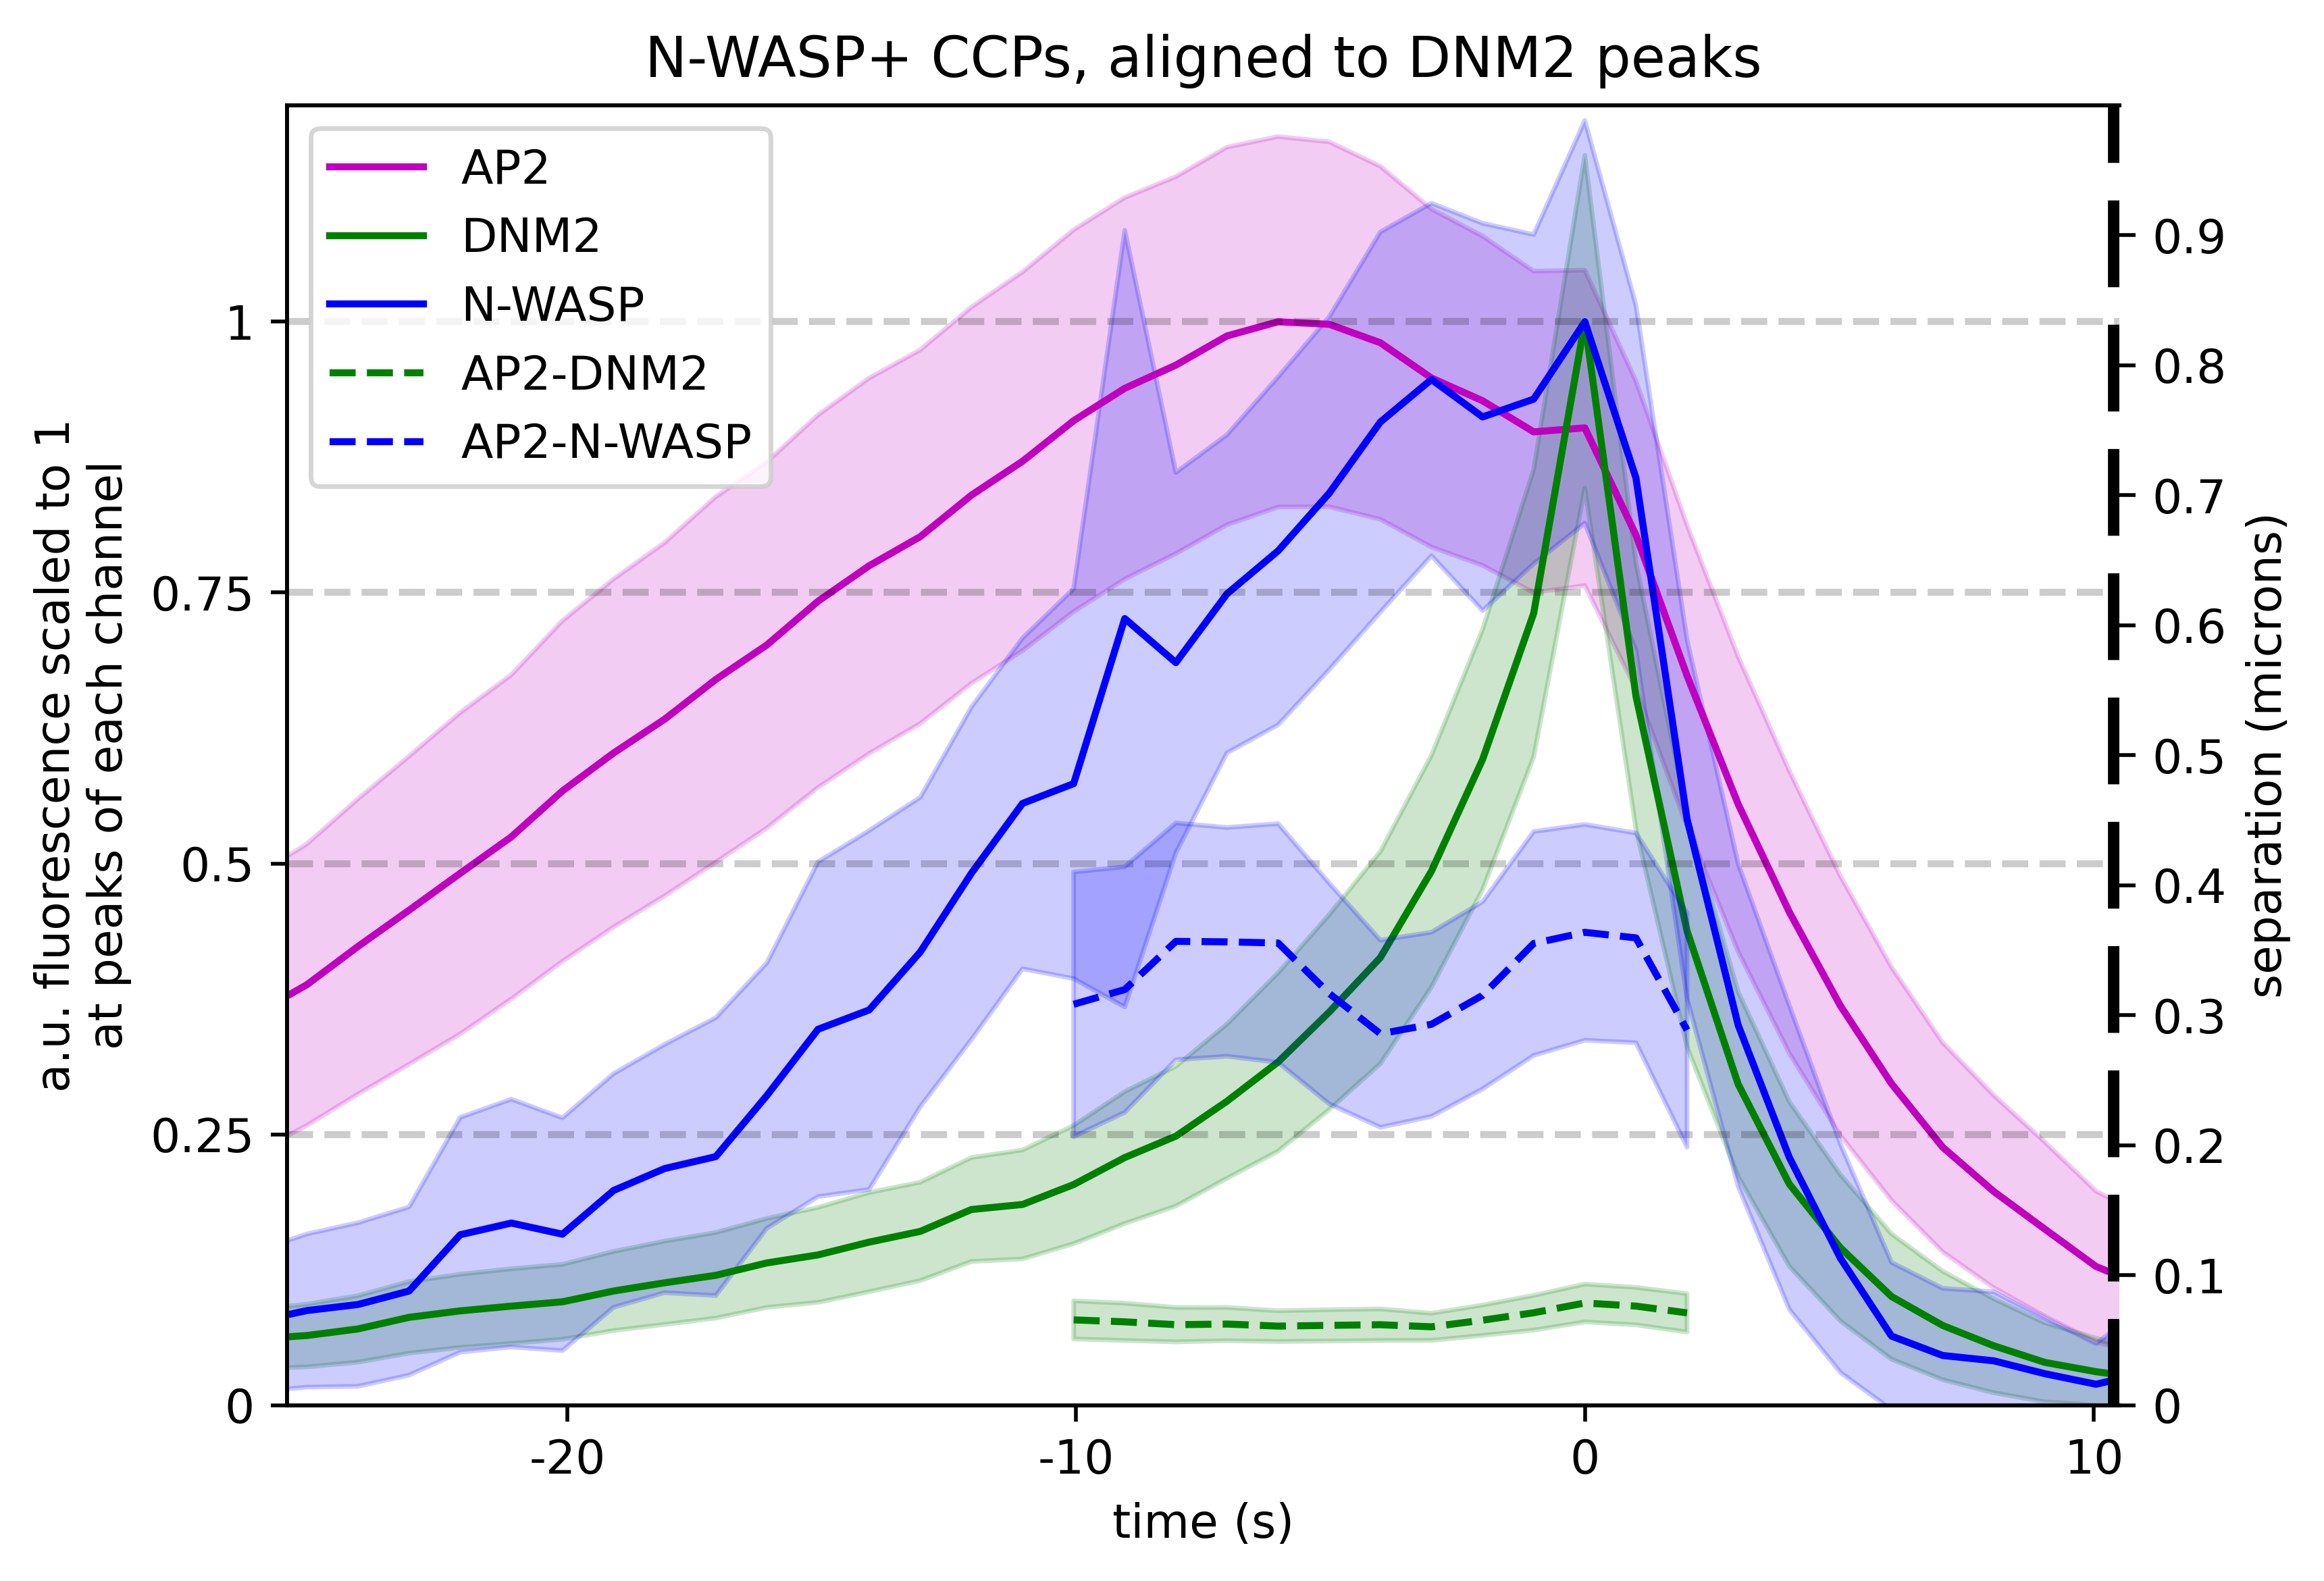

In [71]:
Image(filename=unique_user_saved_outputs+'/plots/fig5b_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_overlaid_separation.png', height=500, width=500)

# N-WASP+ cohort with AP2/DNM2, AP2/N-WASP, DNM2/N-WASP separation

In [76]:
%%capture

plt.style.use('default')
plt.rcParams['axes.spines.right'] = False

fig, axes_0 = plt.subplots(1, 1, dpi=500, figsize=(7,5))
axes_separation_0 = axes_0.twinx()

cohorts = [[min(ap2_lifetime_nwasp_positive), max(ap2_lifetime_nwasp_positive)]]

_, _, max_dnm2_cohort_indices_0 = display_tracks.plot_separated_cohorts([axes_0, axes_separation_0], 
                                                                         channel_amplitudes_nwasp_positive, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [3, 4, 5], 
                                                                         ['AP2', 'DNM2', 'N-WASP', 'AP2-DNM2', 'AP2-N-WASP', 'DNM2-N-WASP'],
                                                                         ['m', 'g', 'b', 'k', 'm', 'g'],
                                                                         line_cutoff_index=[3, 4, 5],
                                                                         line_cutoff_regions=[[], [], [], [[0, 110-10], [113, 150]], [[0, 110-10], [113, 150]], [[0, 110-10], [113, 150]]],
                                                                         horizontal_shift_index=[0, 1, 2, 3, 4, 5], 
                                                                         horizontal_shift=[-110, -110, -110, -110, -110, -110],
                                                                         norm_intensity=True)


                                                                        


lines_0, labels_0 = axes_0.get_legend_handles_labels()
lines_1, labels_1 = axes_separation_0.get_legend_handles_labels()

axes_0.legend(lines_0+lines_1, labels_0+labels_1, 
            loc='upper left')

y_lines = np.arange(0,1.25,0.25)

for i in range(1,len(y_lines)):
    
    axes_0.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

axes_0.set_xlabel('time (s)') 

axes_separation_0.set_ylim([0,1])


axes_0.set_yticks([0,0.25, 0.5, 0.75, 1], minor=False)
axes_0.set_yticklabels([0,0.25, 0.5, 0.75, 1], minor=False)


axes_separation_0.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], minor=False)
axes_separation_0.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], minor=False)

# plt.setp(axes_0.get_xticklabels(), visible=False)
yticks = axes_1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
plt.subplots_adjust(hspace=.0)

axes_0.axvline(11, color='black', linewidth=5, linestyle='--')

# axes_0.text(-31,0, 'a.u. fluorescence scaled to one', rotation="vertical", va="center", fontsize=10);
# axes_0.text(14,0, 'separation (microns)', rotation=270, va="center", fontsize=10);

axes_0.set_xlabel('time (s)') 
axes_0.set_ylabel('a.u. fluorescence scaled to 1\nat peaks of each channel')
axes_0.set_title('N-WASP+ CCPs, aligned to DNM2 peaks')
axes_0.set_xlim([-25, 11]) 

axes_0.set_ylim([0,1.2])

x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[3, 2]]

for i in range(len(max_dnm2_cohort_indices_0)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices_0[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices_0[i])/10)-1),max_ticks_per_cohort[i][1]))
    
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices_0[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices_0[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices_0[i])


# axes_0.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
# axes_0.set_xticklabels(x_labels_ticks, minor=False)
axes_0.set_xticks(0.5+np.array([-20, -10, 0, 10]), minor=False)
axes_0.set_xticklabels([-20, -10, 0, 10], minor=False)


axes_separation_0.set_ylabel('separation (microns)')


plt.savefig(unique_user_saved_outputs+'/plots/fig5b_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_overlaid_separation_dnm2nwasp_sep.png', bbox_inches='tight')
plt.rcParams['axes.spines.right'] = False

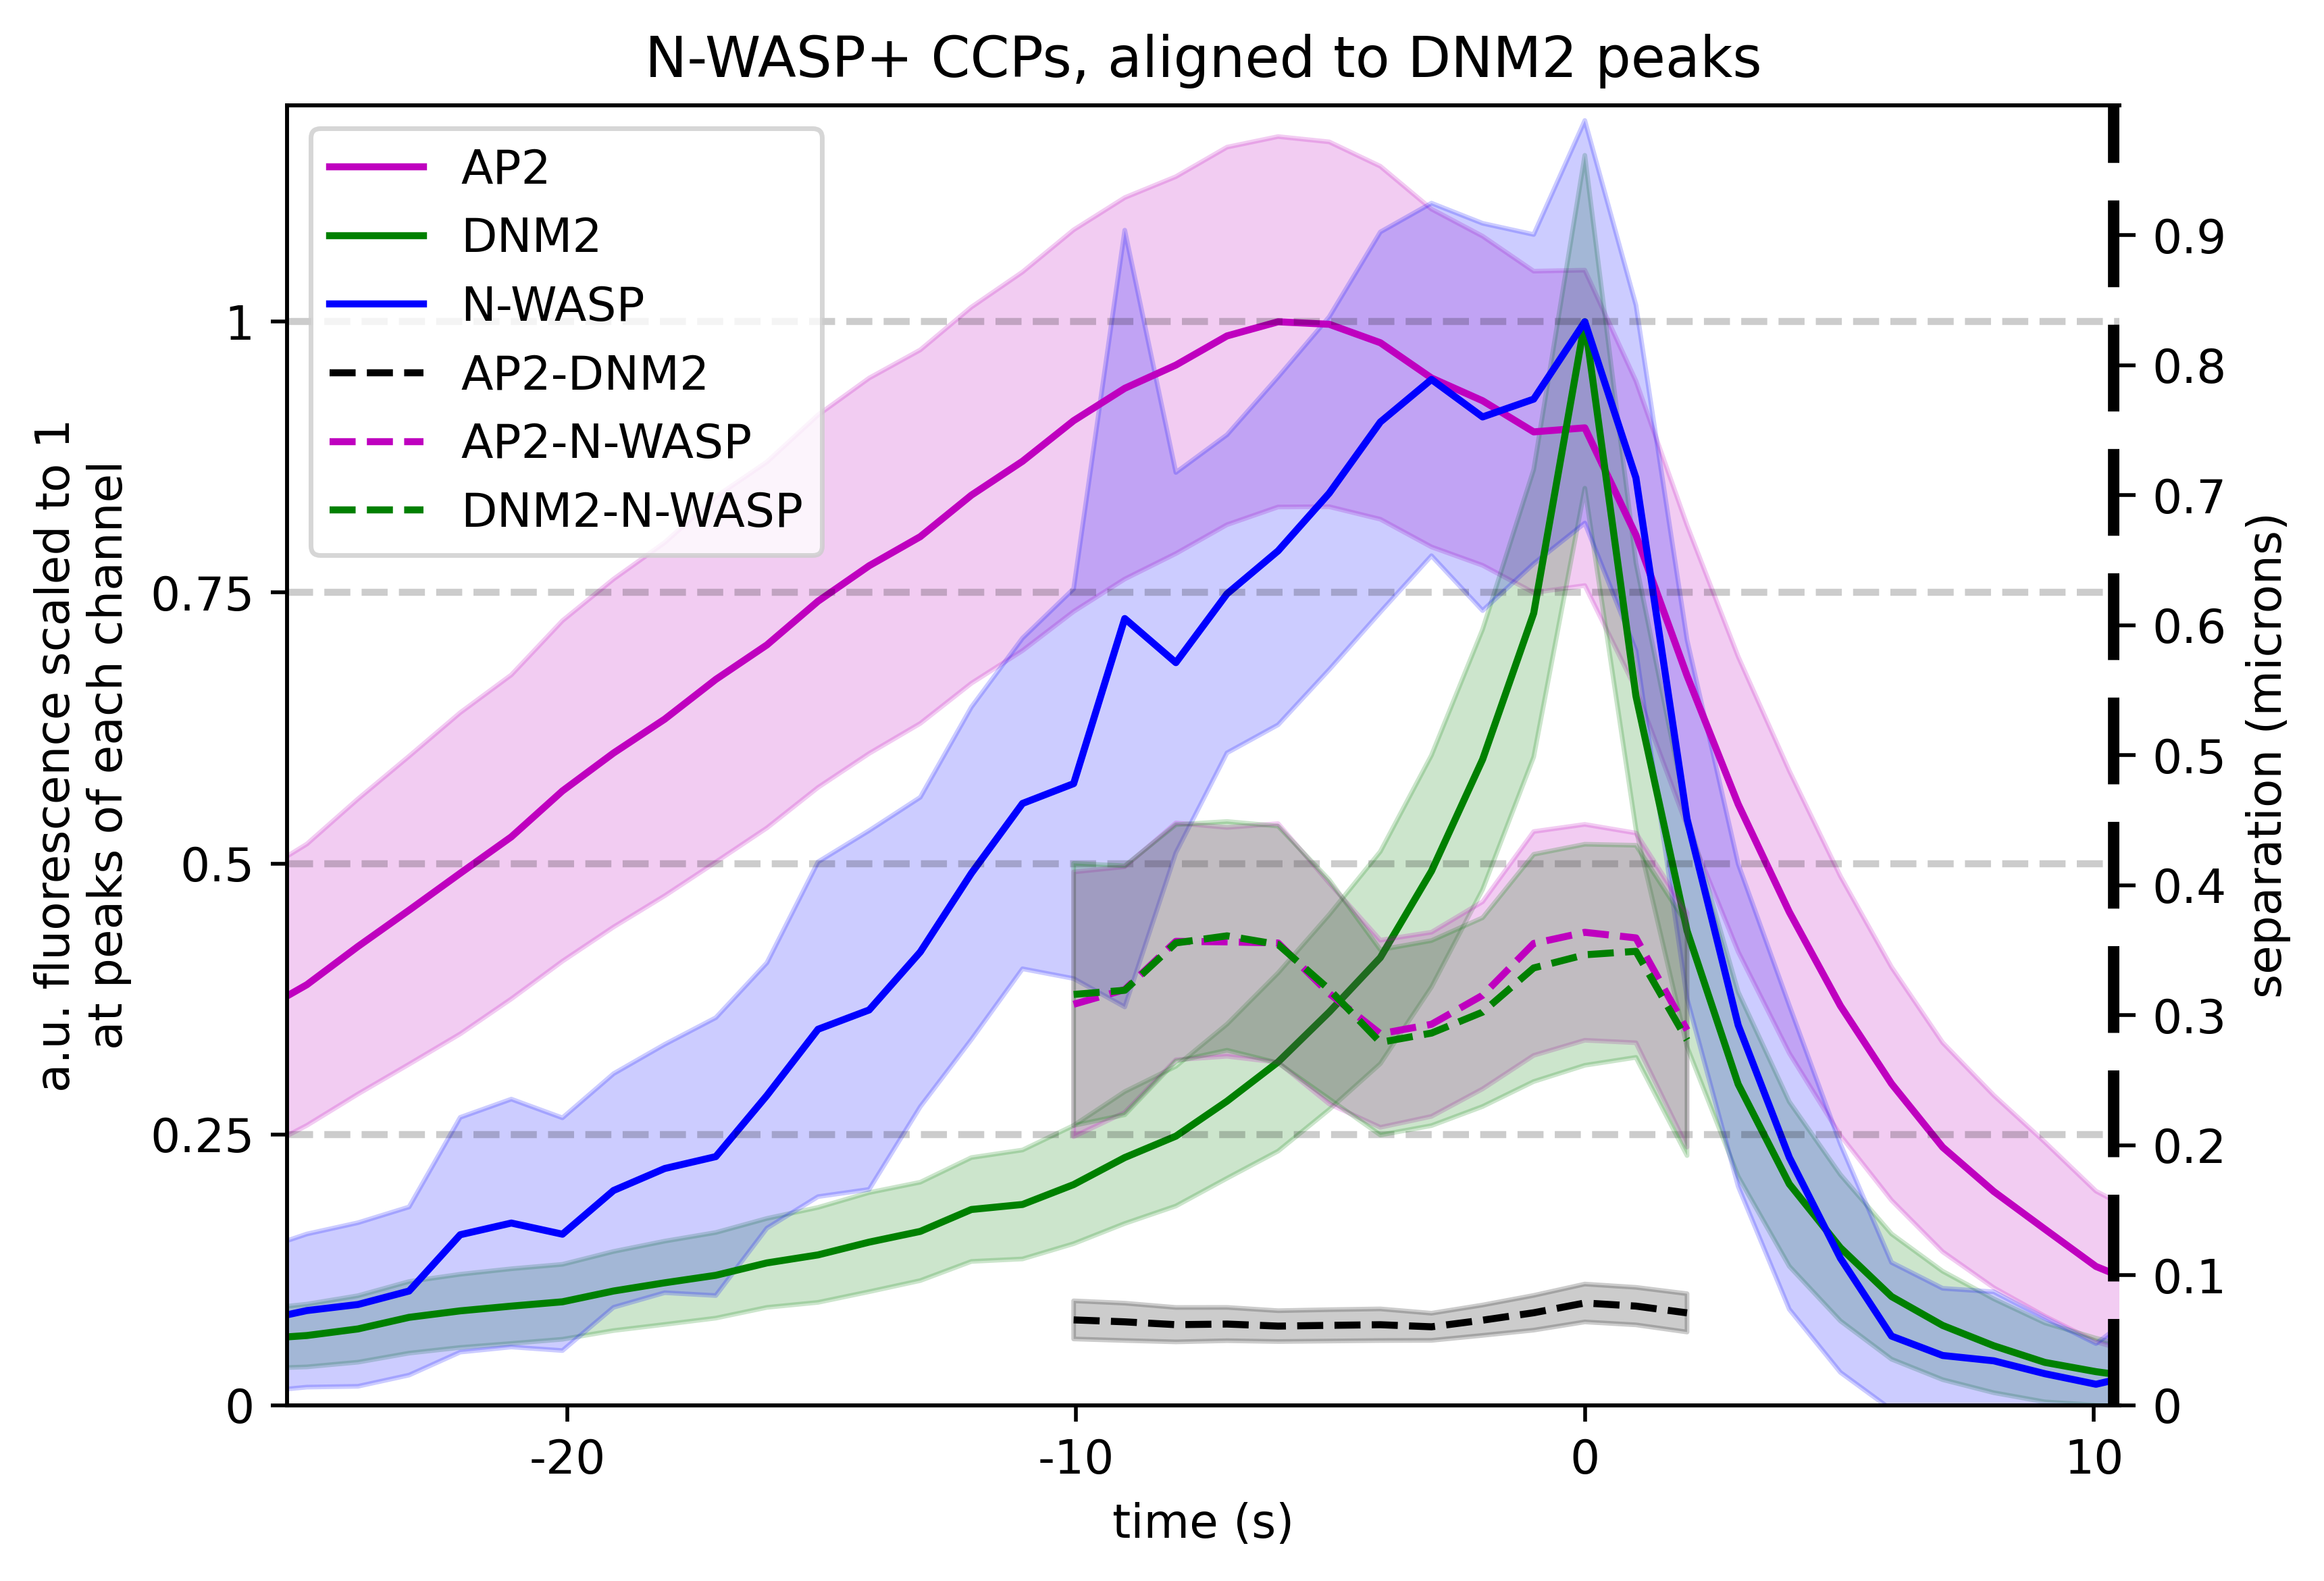

In [77]:
Image(filename=unique_user_saved_outputs+'/plots/fig5b_all_overlaid_ap2dnm2_nwaspplusccps_cohorts_overlaid_separation_dnm2nwasp_sep.png', height=500, width=500)